The goal of this notebook is to determine which cytokines and chemokines are found at high levels in pyroptotic inducing agents.
Doing this will allow us to determine ground truth of pyroptosis occurance.

### Imports

In [1]:
import pathlib

# umap analysis of treatment groups
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import toml
import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
from scipy.cluster.hierarchy import linkage
from scipy.stats import f_oneway

# post hoc test for 'VEGF-C [NSU]' column using Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# anova test on each group


warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)
import umap

In [2]:
# set path

df_path = pathlib.Path(
    f"../../Data/clean/Plate2/nELISA_plate_430420_SHSY5Y_clean.parquet"
)


# read in the data
df = pd.read_parquet(df_path)

In [3]:
# import selected treatmenets
# set path
toml_path = pathlib.Path("../../../1.Exploratory_Data_Analysis/utils/params.toml")

# read in toml file
params = toml.load(toml_path)
list_of_treatments = params["list_of_treatments"]["treatments"]

In [4]:
# get the treatments in fourb_Metadata_Treatment_Dose_Inhibitor coulumn for each treatment in the list of treatments
df = df.drop(
    columns=[
        "Dose",
        "Treatment",
        "twob_Treatment_Dose_Inhibitor_Dose",
        "threeb_Treatment_Dose_Inhibitor_Dose",
        "fourb_Treatment_Dose_Inhibitor_Dose",
    ]
)
# if column name does not contain [NSU], add Metadata_ to the beginning of the column name
df.columns = ["Metadata_" + col if "[NSU]" not in col else col for col in df.columns]

df_metadata = df[df.columns[df.columns.str.contains("Metadata")]]
# non_metadata_cols
df = df.drop(columns=df_metadata.columns)
df["oneb_Treatment_Dose_Inhibitor_Dose"] = df_metadata[
    "Metadata_oneb_Treatment_Dose_Inhibitor_Dose"
]
df["Metadata_position_x"] = df_metadata["Metadata_position_x"]

In [5]:
# set output path
all_cytokines_path = pathlib.Path(
    f"./results/SHSY5Y_all_cytokine_values_per_treatment_per_well.parquet"
)
all_cytokines_path_melted = pathlib.Path(
    f"./results/SHSY5Y_all_cytokine_values_per_treatment_per_well_melted.parquet"
)
df.to_parquet(all_cytokines_path)

df_melted = df.melt(
    id_vars=["Metadata_position_x", "oneb_Treatment_Dose_Inhibitor_Dose"],
    var_name="cytokine",
    value_name="cytokine_value",
)

df_melted.to_parquet(all_cytokines_path_melted)

In [6]:
# aggregate the data by treatment with mean
df_melted_truth = (
    df_melted.groupby(["oneb_Treatment_Dose_Inhibitor_Dose", "cytokine"])
    .mean()
    .reset_index()
)
# drop all cytokines except for IL-1 beta [NSU] and CCL24 [NSU]
df_melted_truth = df_melted_truth[
    df_melted_truth["cytokine"].isin(
        ["IL-1 beta [NSU]", "CCL24 [NSU]", "Osteopontin (OPN) [NSU]"]
    )
].reset_index(drop=True)


# split the cytokine column into two columns: il1b and ccl24
df_melted_truth = df_melted_truth.pivot(
    index="oneb_Treatment_Dose_Inhibitor_Dose", columns="cytokine"
).reset_index()
# reset the multiindex
df_melted_truth.columns = [
    "_".join(col).strip() if col[1] else col[0]
    for col in df_melted_truth.columns.values
]

In [7]:
# if ccl24 is greater than 0.5, then add 1 to the a new column called ccl24_positive
df_melted_truth["ccl24_positive"] = np.where(
    df_melted_truth["cytokine_value_CCL24 [NSU]"] > 0.5, 1, 0
)
# if il1b is greater than 0.5, then add 1 to the a new column called il1b_positive
df_melted_truth["il1b_positive"] = np.where(
    df_melted_truth["cytokine_value_IL-1 beta [NSU]"] > 0.5, 1, 0
)
# if opn is greater than 0.5, then add 1 to the a new column called opn_positive
df_melted_truth["opn_positive"] = np.where(
    df_melted_truth["cytokine_value_Osteopontin (OPN) [NSU]"] > 0.5, 1, 0
)

# make a new column called label and use conditionals to assign the label
df_melted_truth["label"] = np.where(
    # ccl24 +, il1b + = death
    (df_melted_truth["ccl24_positive"] == 1) & (df_melted_truth["il1b_positive"] == 1),
    "death",
    np.where(
        # ccl24 +, il1b - = apoptosis
        (df_melted_truth["ccl24_positive"] == 1)
        & (df_melted_truth["il1b_positive"] == 0),
        "apoptosis",
        np.where(
            # ccl24 -, il1b + = pyroptosis
            (df_melted_truth["ccl24_positive"] == 0)
            & (df_melted_truth["il1b_positive"] == 1),
            "pyroptosis",
            # ccl24 -, il1b - = healthy
            "healthy",
        ),
    ),
)

In [8]:
# get a list of treatments that are labeled as healthy
healthy_list = df_melted_truth[df_melted_truth["label"] == "healthy"][
    "oneb_Treatment_Dose_Inhibitor_Dose"
].tolist()
apoptosis_list = df_melted_truth[df_melted_truth["label"] == "apoptosis"][
    "oneb_Treatment_Dose_Inhibitor_Dose"
].tolist()
pyroptosis_list = df_melted_truth[df_melted_truth["label"] == "pyroptosis"][
    "oneb_Treatment_Dose_Inhibitor_Dose"
].tolist()
death_list = df_melted_truth[df_melted_truth["label"] == "death"][
    "oneb_Treatment_Dose_Inhibitor_Dose"
].tolist()
death_list

# write the lists to a toml file
toml_path = pathlib.Path(
    "../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml"
)
with open(toml_path, "w") as f:
    toml.dump(
        {
            # section name
            "Apoptosis": {
                # key value pair
                "apoptosis_groups_list": apoptosis_list,
            },
            "Pyroptosis": {
                "pyroptosis_groups_list": pyroptosis_list,
            },
            "Healthy": {"healthy_groups_list": healthy_list},
        },
        f,
    )

## Anova and Post-Hoc Analysis
Anova of all treatments and post-hoc analysis of all treatments for each cytokine and chemokine. 
This will determine the cytokines and chemokines that are found at high levels in pyroptotic inducing agents.

In [9]:
# define blank df|
final_df_tukey = pd.DataFrame(
    {
        "group1": [""],
        "group2": [""],
        "meandiff": [""],
        "lower": [""],
        "upper": [""],
        "reject": [""],
        "p-adj": [""],
        "cytokine": [""],
    }
)

In [10]:
# merge the df_melted_truth and df on the oneb_Treatment_Dose_Inhibitor_Dose  and label columns
df = df.merge(df_melted_truth, on="oneb_Treatment_Dose_Inhibitor_Dose")
# drop the columns that are not needed
df = df.drop(
    columns=[
        "oneb_Treatment_Dose_Inhibitor_Dose",
        "Metadata_position_x",
        "cytokine_value_CCL24 [NSU]",
        "cytokine_value_IL-1 beta [NSU]",
        "cytokine_value_Osteopontin (OPN) [NSU]",
        "ccl24_positive",
        "il1b_positive",
        "opn_positive",
    ]
)
df.head()

Activin A [NSU]  AITRL (GITR Ligand) [NSU]  Amphiregulin [NSU]  \
0         0.595518                   0.564662            0.538727   
1         0.582571                   0.559309            0.401775   
2         0.373761                   0.764406            0.207573   
3         0.629170                   0.553058            0.343195   
4         0.549004                   0.856272            0.127459   

   Amyloid beta [NSU]  APRIL [NSU]  BAFF [NSU]  BCMA (TNFRSF17) [NSU]  \
0            0.751911     0.796710    0.506570               0.557007   
1            0.742822     0.746787    0.274090               0.454562   
2            0.347260     0.588432    0.634108               0.699703   
3            0.672494     0.600896    0.403740               0.532554   
4            0.070602     0.810357    0.359850               0.600601   

   BDNF [NSU]  BMP2 [NSU]  BMP3 [NSU]  ...  uPA [NSU]  VCAM-1 [NSU]  \
0    0.000000    0.130110    0.585972  ...   0.180171      0.524795   
1    0.312282    0.345924    0.546424  ...   0.238207      0.511600   
2    0.553857    0.570628    0.519550  ...   0.065509      0.404198   
3    0.426813    0.684052    0.657260  ...   0.240577      0.302402   
4    0.682277    0.288149    0.681883  ...   0.305277      0.271509   

   VEGF Receptor 2 (Flk-1) [NSU]  VEGF-A (165) [NSU]  VEGF-C [NSU]  \
0                       0.299154            0.296559      0.278150   
1                       0.548511            0.390647      0.095667   
2                       0.489385            0.387342      0.238013   
3                       0.743325            0.358997      0.314992   
4                       0.767602            0.260110      0.250799   

   VEGF-D [NSU]  VEGFR-1 [NSU]  WISP-1 (CCN4) [NSU]  \
0      0.570920       0.344809             0.232809   
1      0.254588       0.424436             0.746510   
2      0.617017       0.584297             0.293839   
3      0.351843       0.406837             0.269695   
4      0.457524       0.225962             0.300728   

   XCL1 (Lymphotactin) [NSU]       label  
0                   0.725177  pyroptosis  
1                   0.841049  pyroptosis  
2                   0.886628  pyroptosis  
3                   0.862941  pyroptosis  
4                   0.459638  pyroptosis  

[5 rows x 188 columns]

In [11]:
# perform anova on each column of the data frame with oneb_meta as the groupby
alpha = 0.05
alpha_adj = alpha / (len(df.columns) - 1)
columns = df.columns
# drop the labels column
columns = columns.drop("label")
for i in tqdm.tqdm(columns):
    tukey = pairwise_tukeyhsd(
        endog=df[i],
        groups=df["label"],
        alpha=alpha_adj,
    )
    # send the results to a dataframe
    tukey_results = pd.DataFrame(
        data=tukey._results_table.data[1:], columns=tukey._results_table.data[0]
    )
    tukey_results["cytokine"] = f"{i}"
    # concat the results to the blank df
    final_df_tukey = pd.concat([final_df_tukey, tukey_results], axis=0)

100%|██████████| 187/187 [00:19<00:00,  9.73it/s]


In [12]:
# remove first row as it is blank fro some reason
final_df_tukey = final_df_tukey.iloc[1:]
final_df_tukey.head(3)
# merge the group1 and group2 columns to form a new column called group
final_df_tukey["group"] = final_df_tukey["group1"] + "_" + final_df_tukey["group2"]
final_df_tukey.head(3)

group1      group2 meandiff   lower   upper reject   p-adj  \
0  apoptosis     healthy  -0.1196  -0.407  0.1677  False  0.2184   
1  apoptosis  pyroptosis  -0.1175 -0.4014  0.1663  False  0.2219   
2    healthy  pyroptosis   0.0021 -0.1257  0.1299  False  0.9976   

          cytokine                 group  
0  Activin A [NSU]     apoptosis_healthy  
1  Activin A [NSU]  apoptosis_pyroptosis  
2  Activin A [NSU]    healthy_pyroptosis

In [13]:
final_df_tukey.head(4)
# change the p-adj column to a float
final_df_tukey["p-adj"] = final_df_tukey["p-adj"].astype(float)
# replace -0 with 0
final_df_tukey["p-adj"] = final_df_tukey["p-adj"].replace([-0], 0)
# create a -log10(p-adj) column
final_df_tukey["-log10(p-adj)"] = -np.log10(final_df_tukey["p-adj"])
final_df_tukey["-log10(p-adj)"].unique()
# replcae inf with 4
final_df_tukey["-log10(p-adj)"] = final_df_tukey["-log10(p-adj)"].replace([np.inf], 4)

In [14]:
# sort the df by p-adj
final_df_tukey = final_df_tukey.sort_values(by=["-log10(p-adj)"], ascending=[True])

# filter the data for significanct post hoc tests
If we see two high dose groups of pyroptotic treatments in this p-adj value < 0.05 data then we can toss it. 
This implies a variable treatment. 
We are primarily interested in which cytokines best differentiate between control, apoptosis, and pyroptosis

In [15]:
final_df_tukey["cytokine"].unique()
# create output path for the df
output_path = pathlib.Path(f"./results/tukey_unfiltered_nomic_results.csv")
# save the df
final_df_tukey.to_csv(output_path)

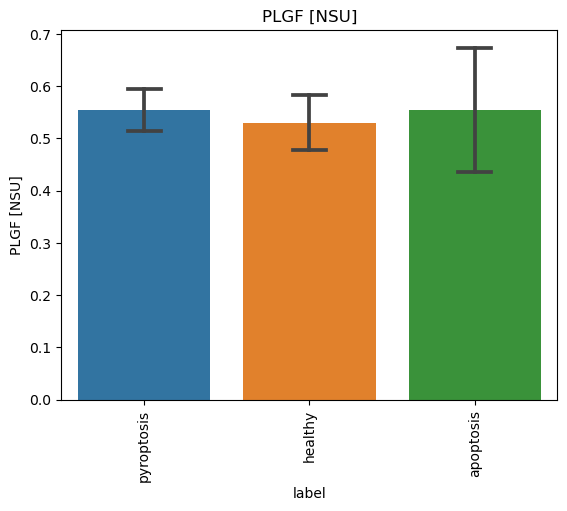

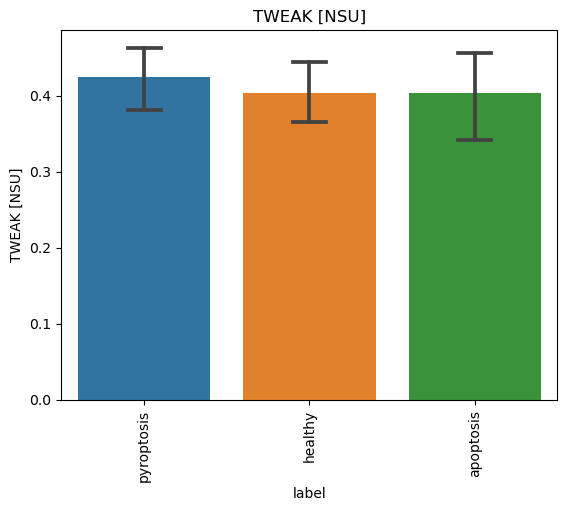

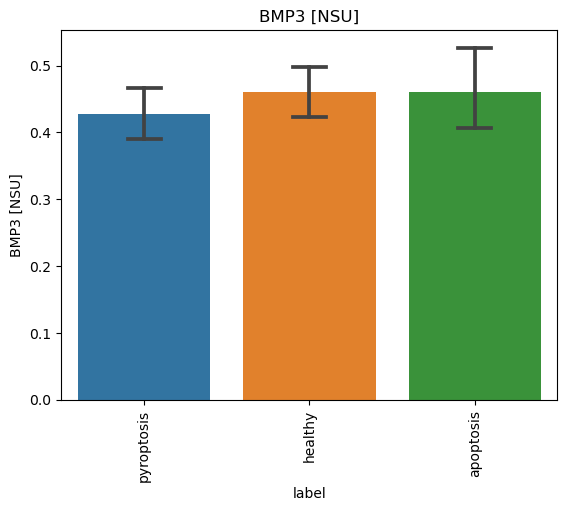

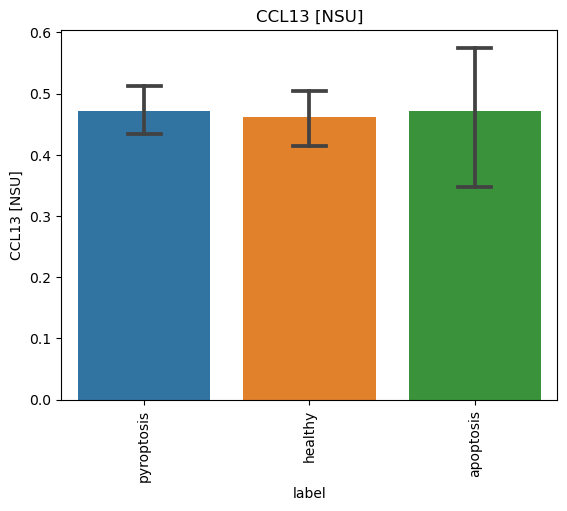

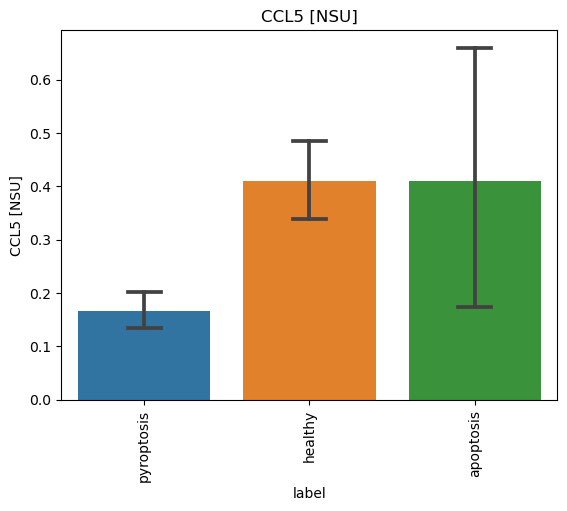

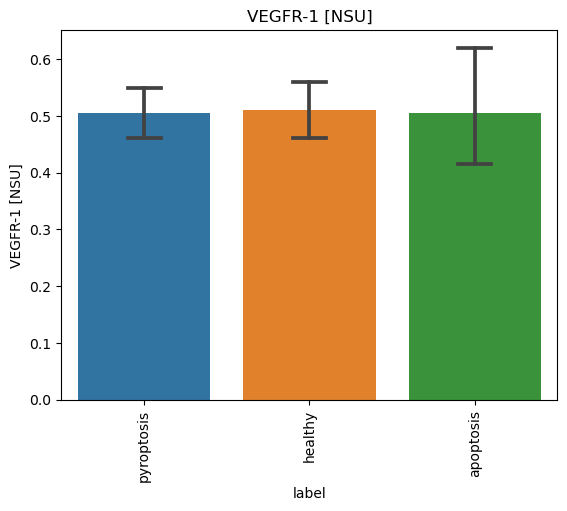

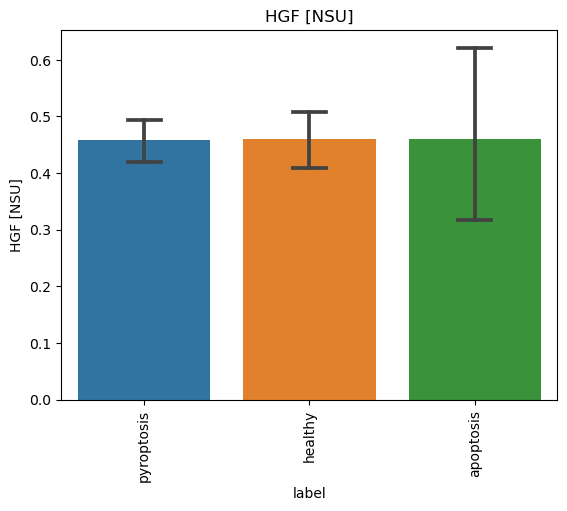

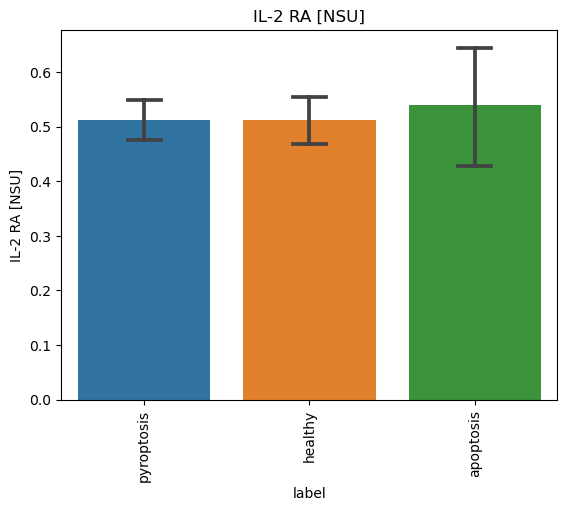

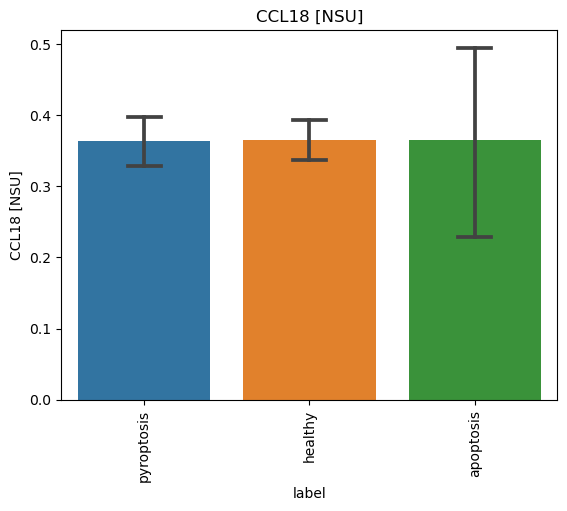

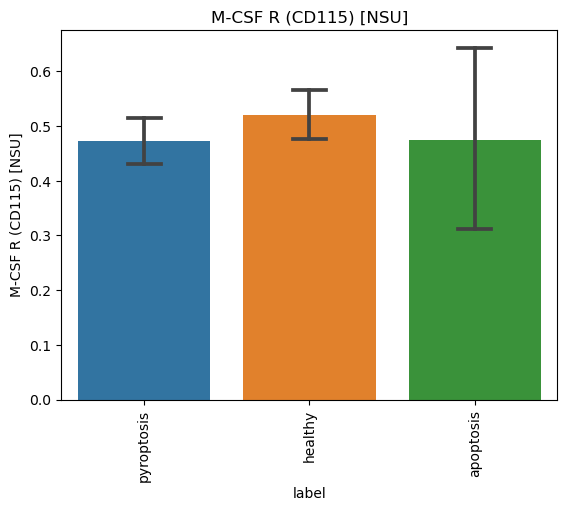

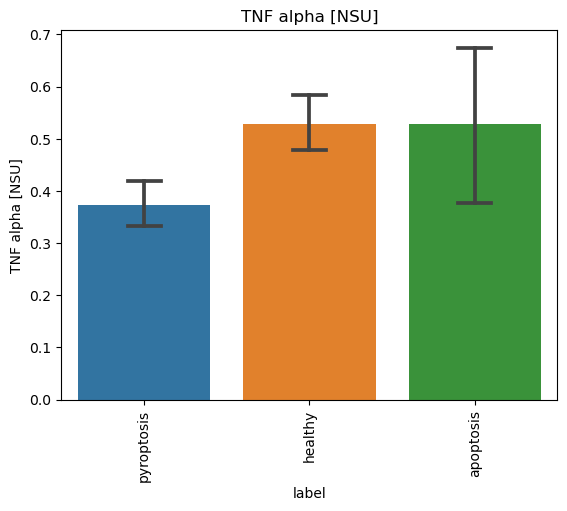

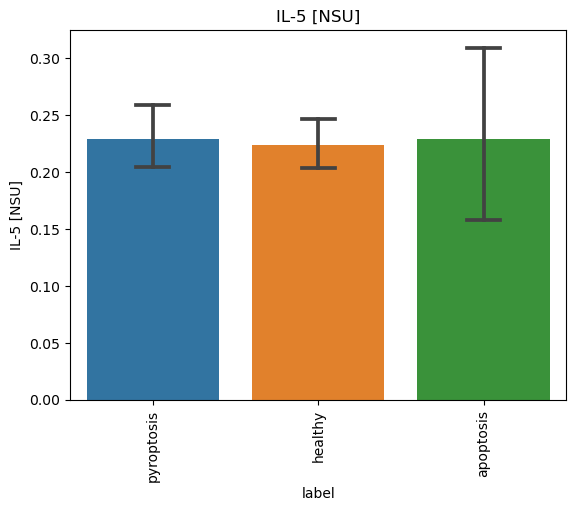

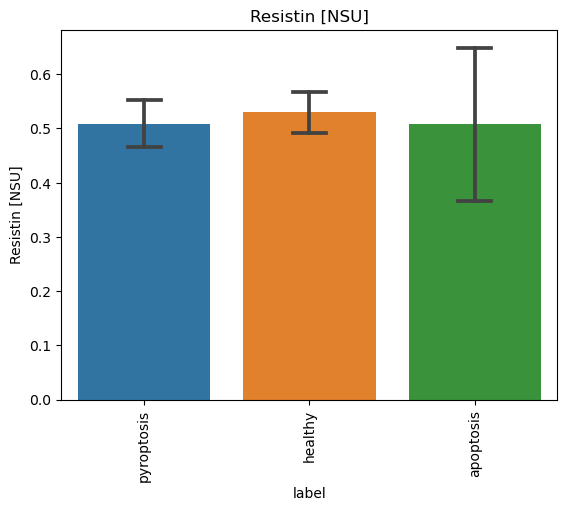

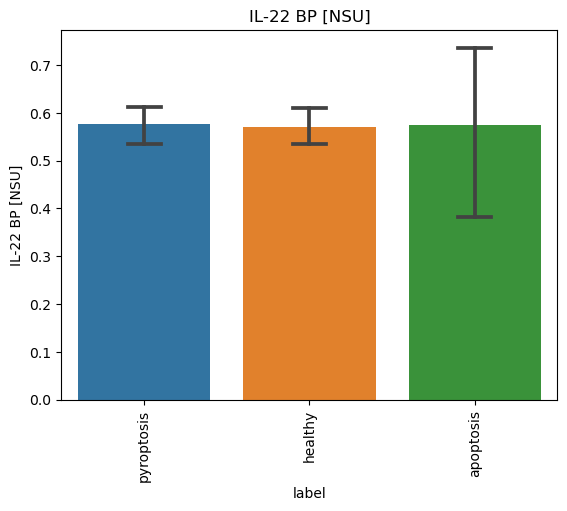

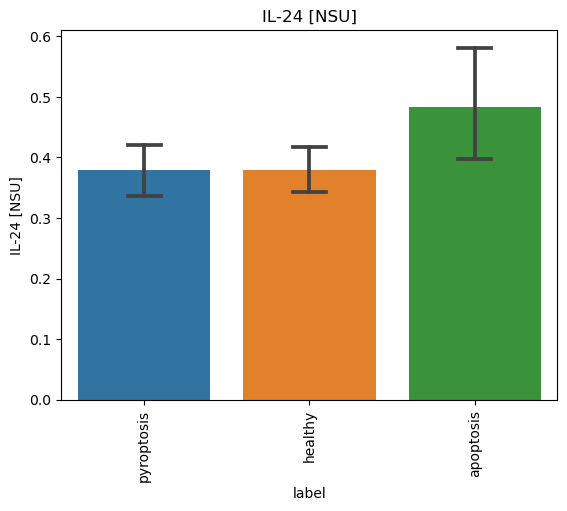

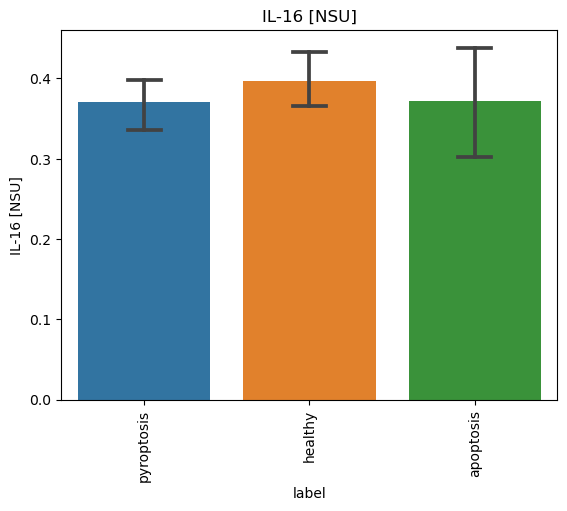

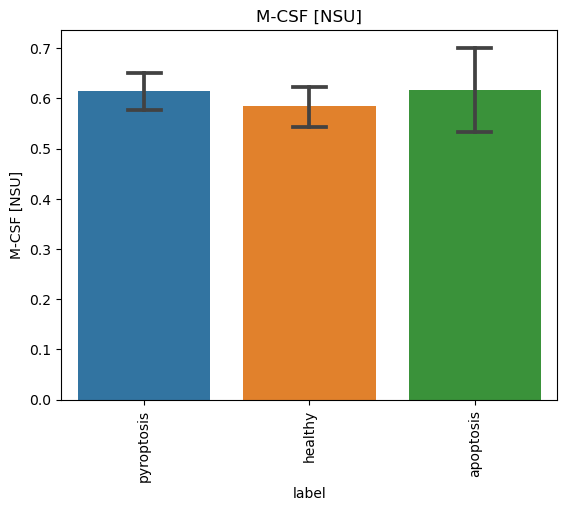

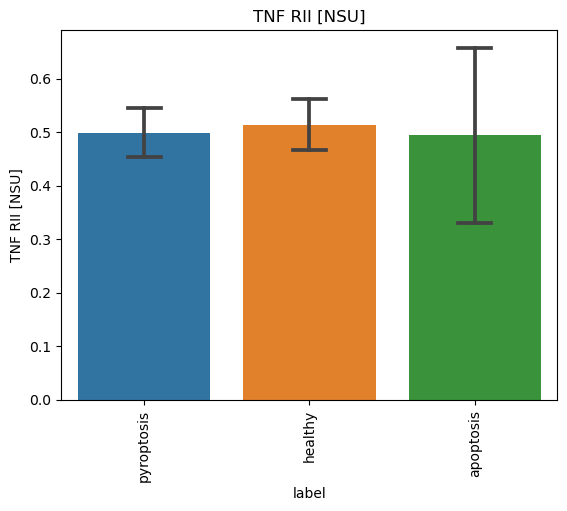

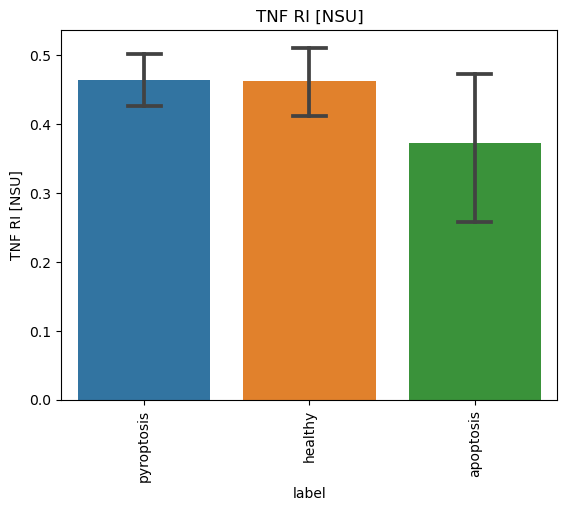

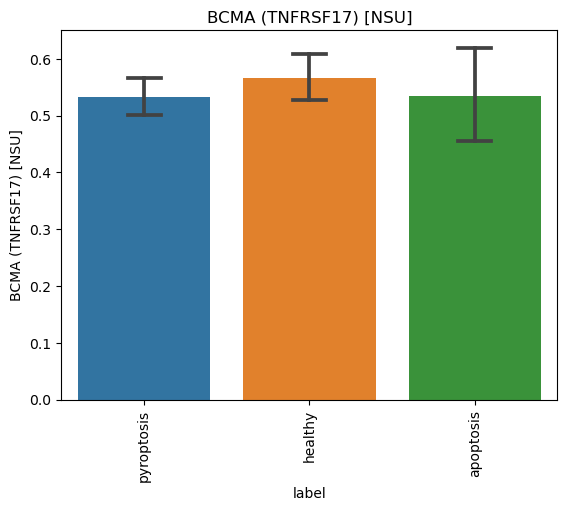

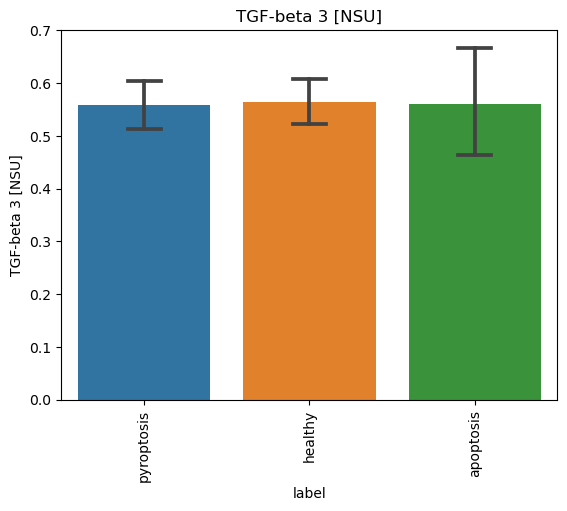

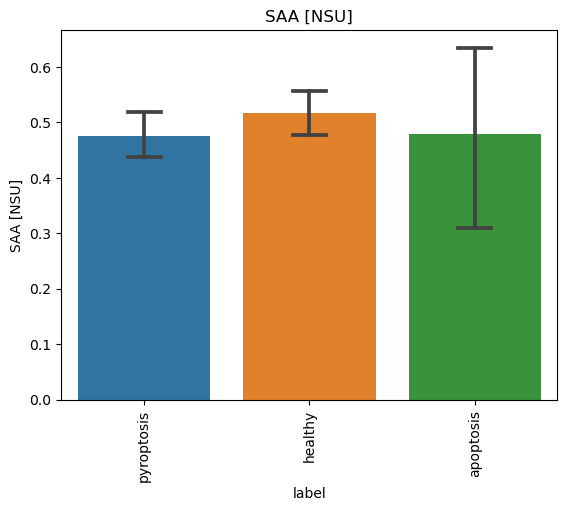

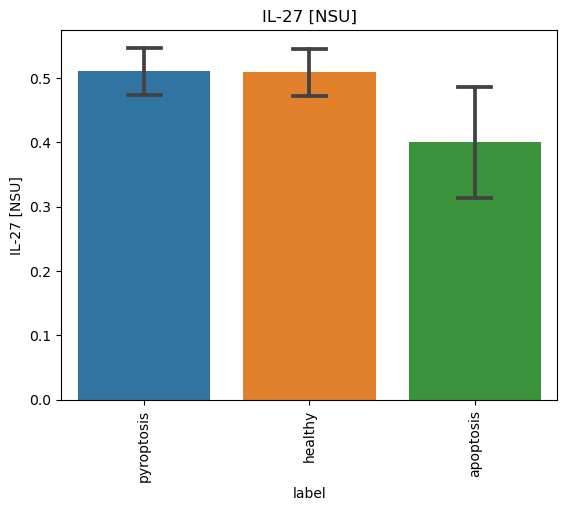

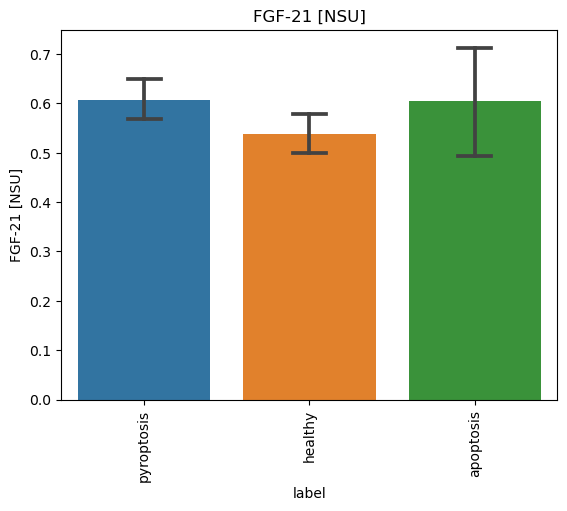

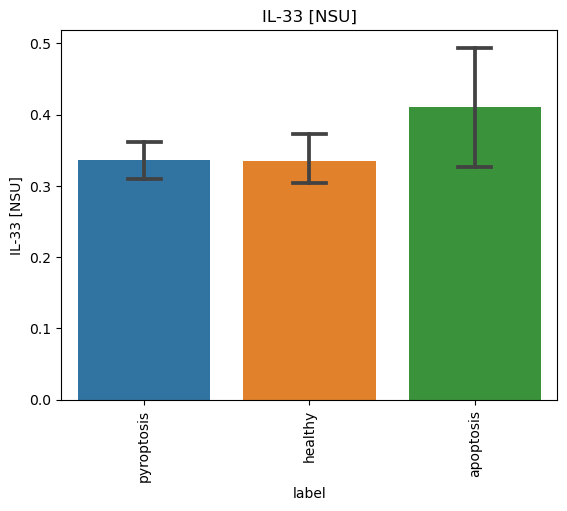

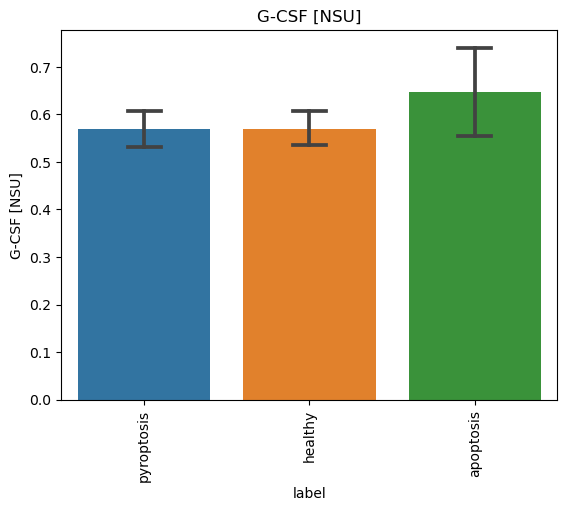

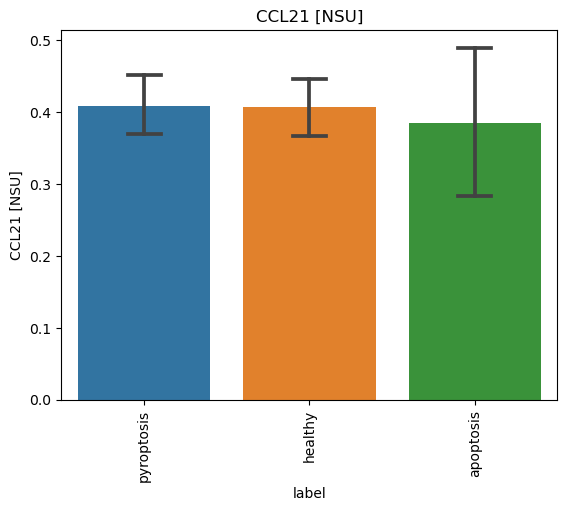

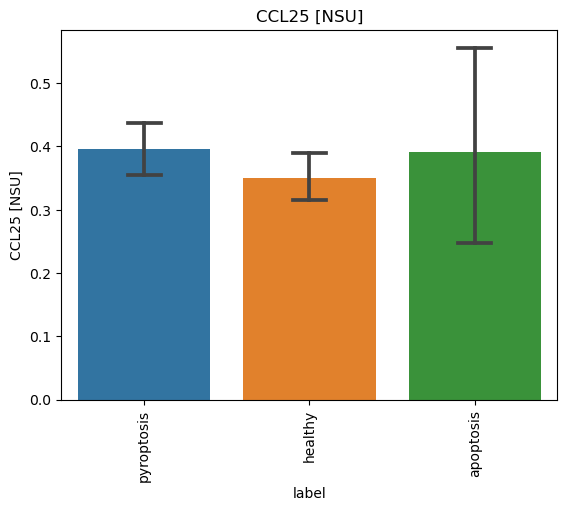

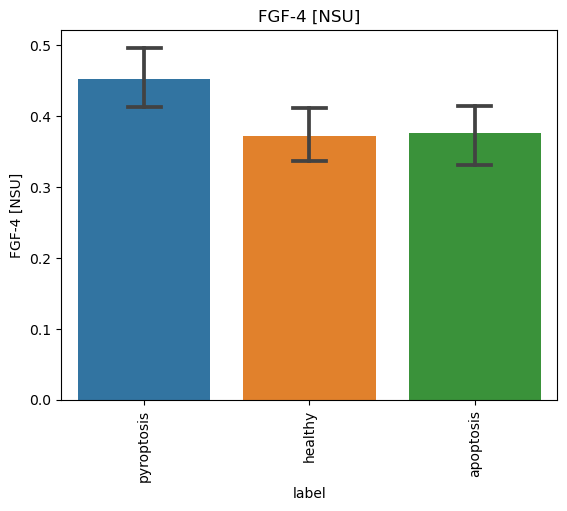

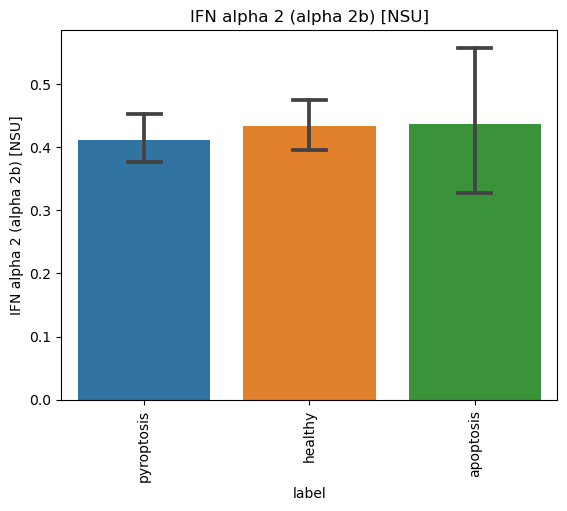

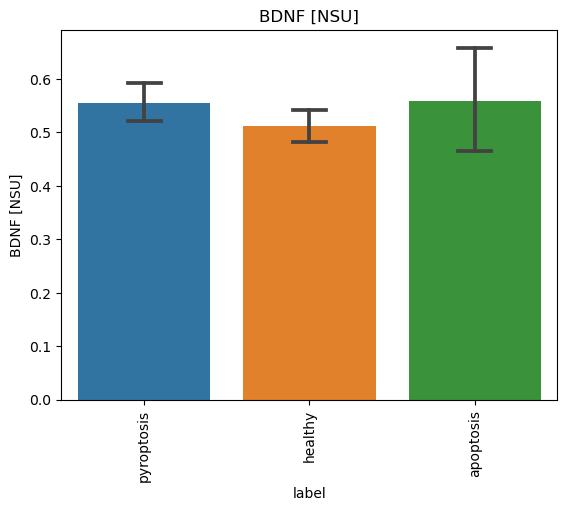

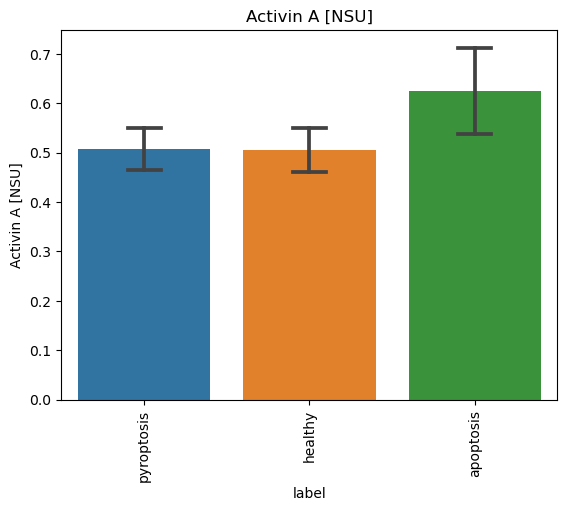

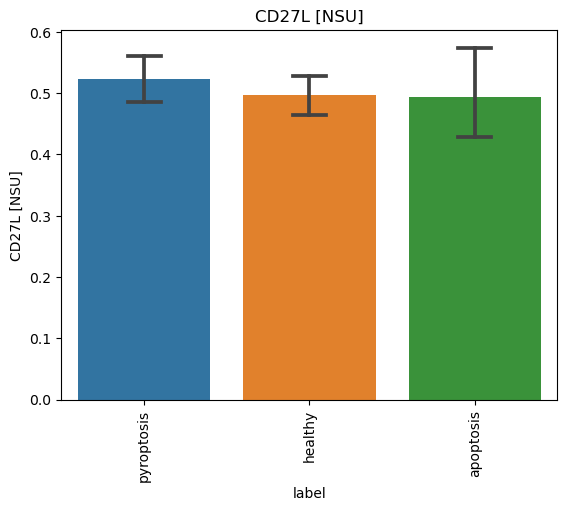

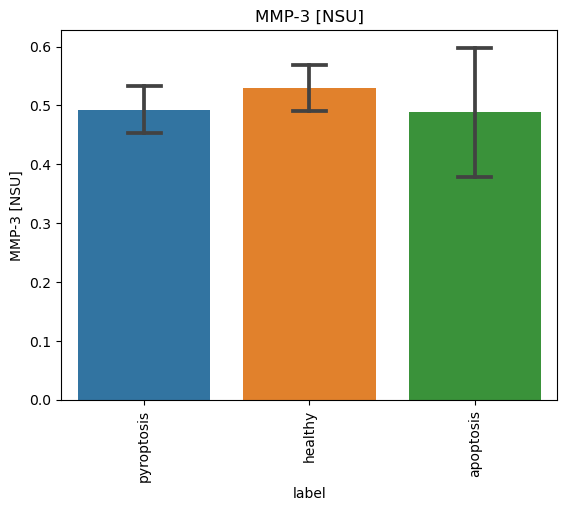

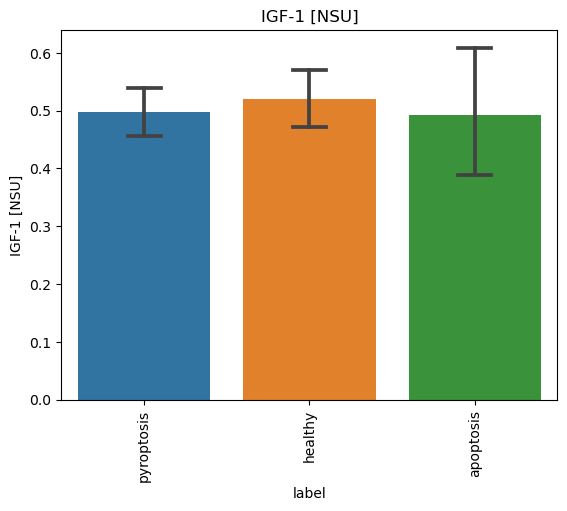

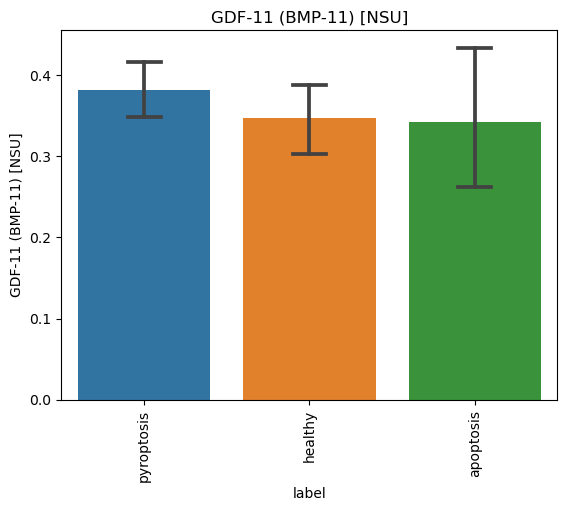

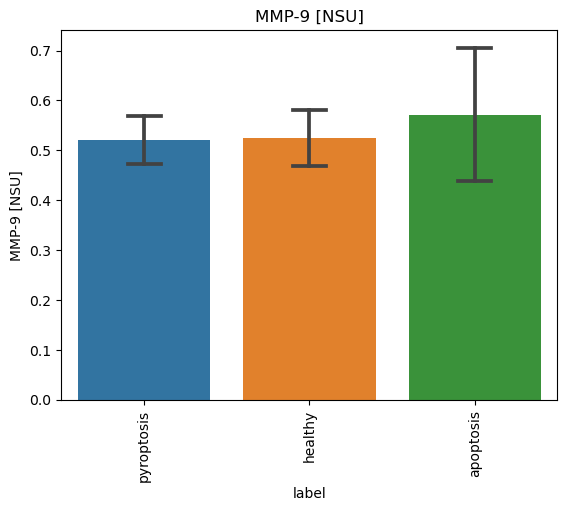

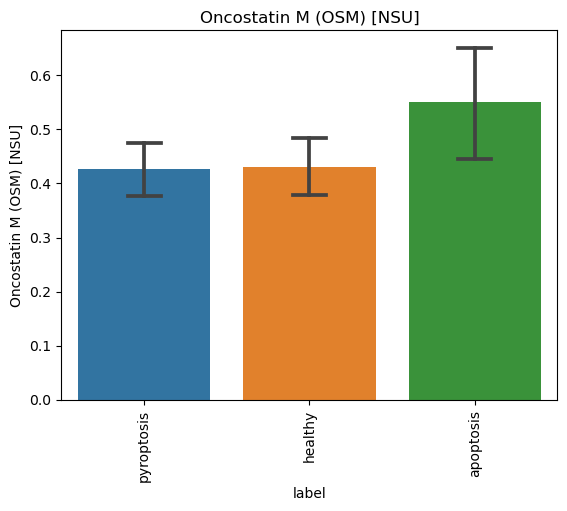

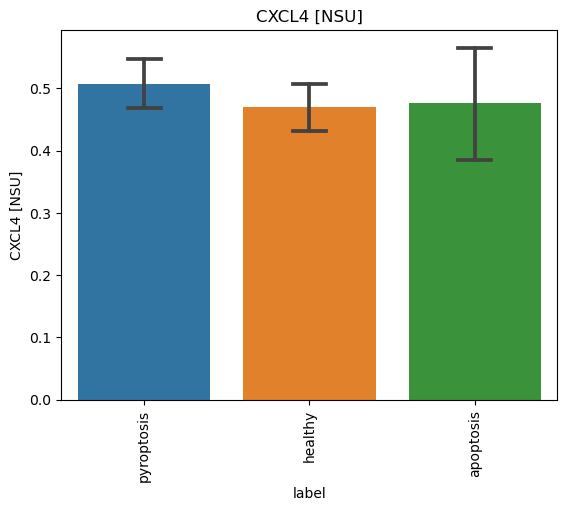

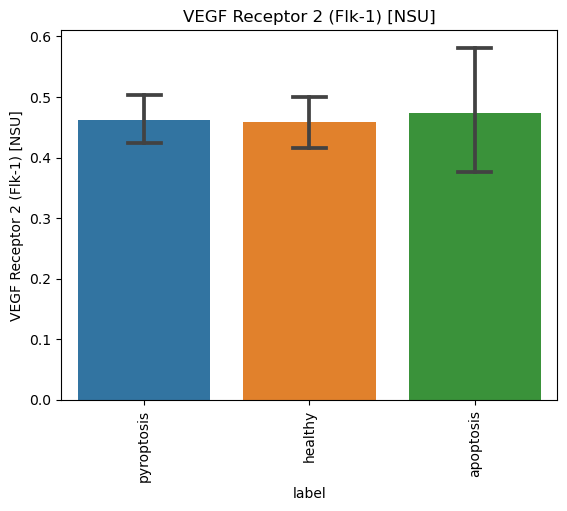

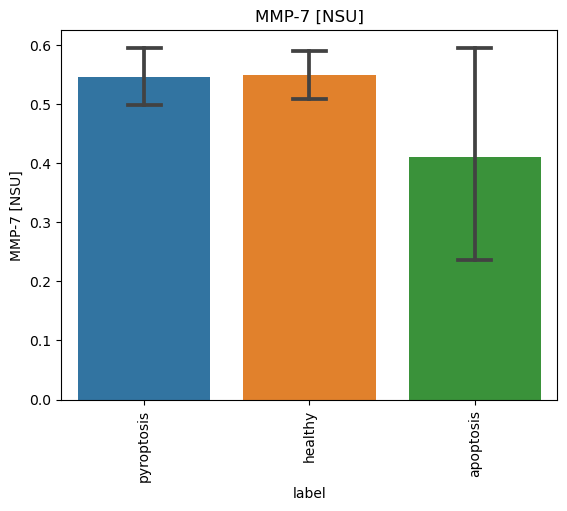

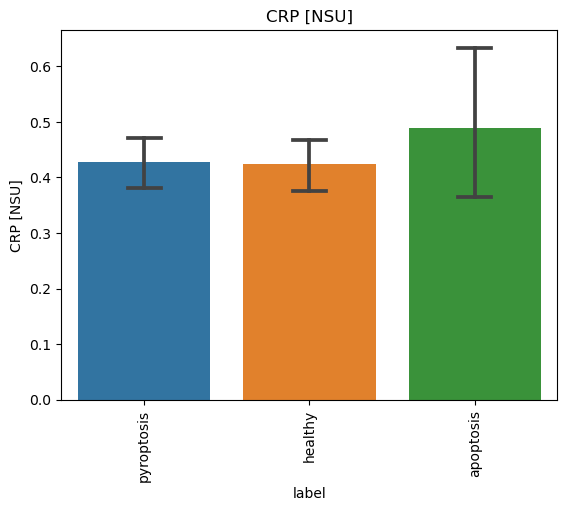

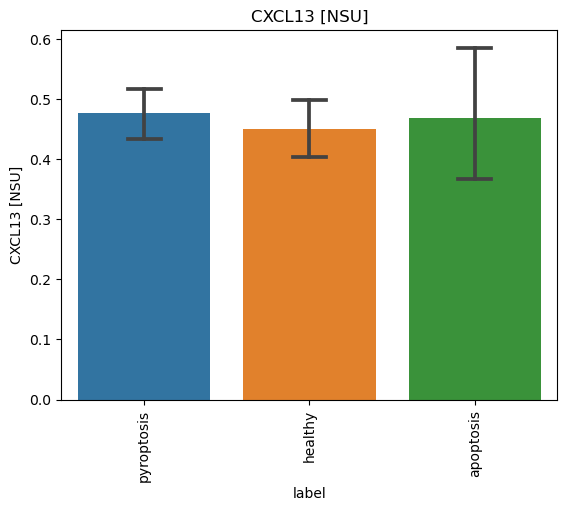

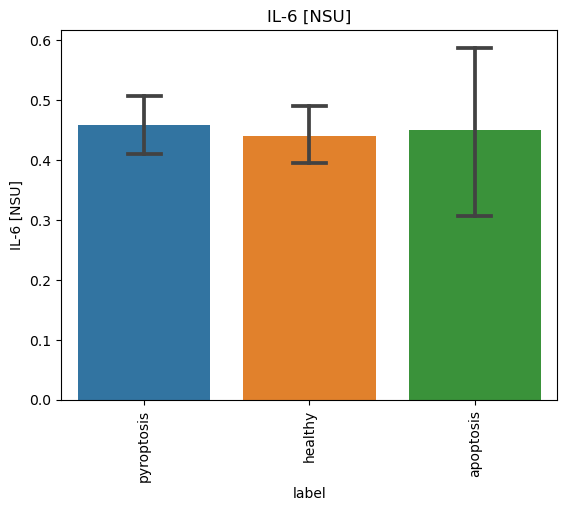

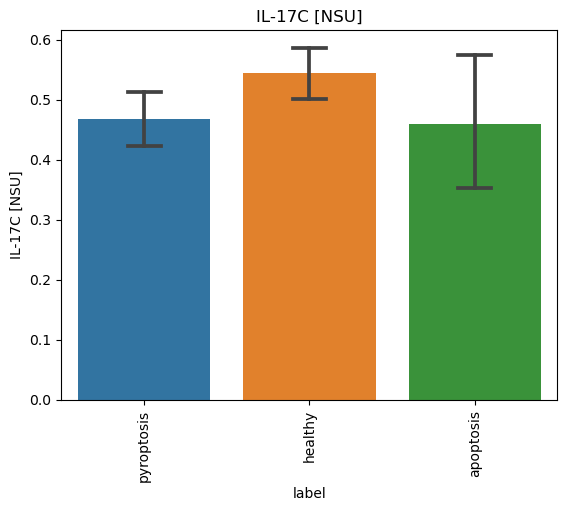

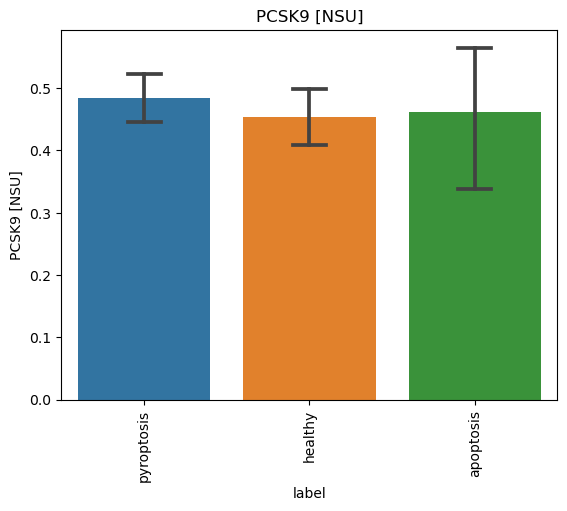

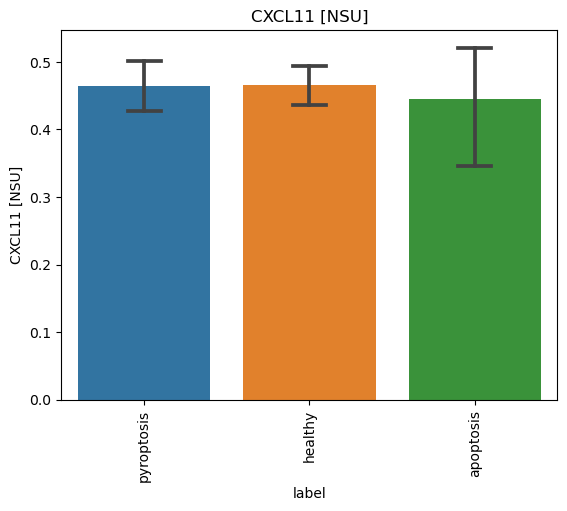

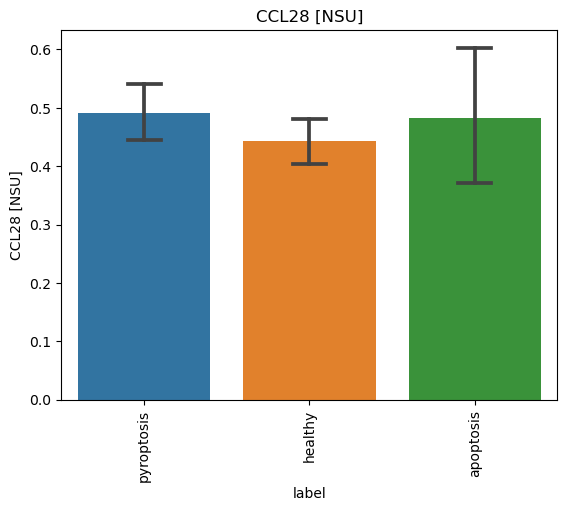

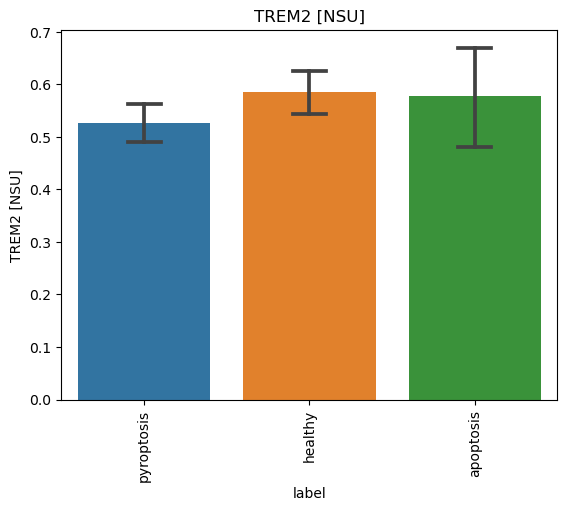

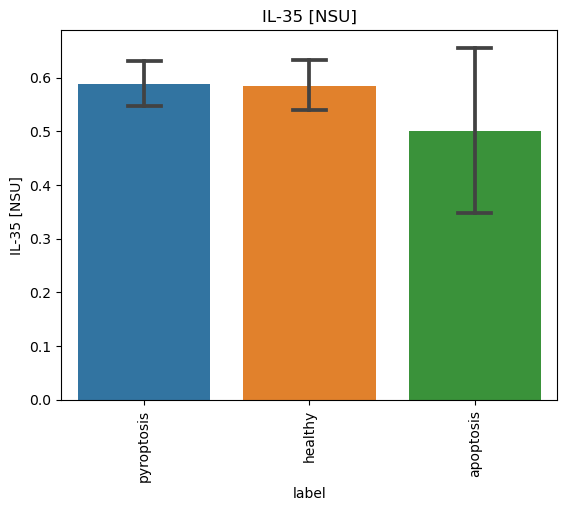

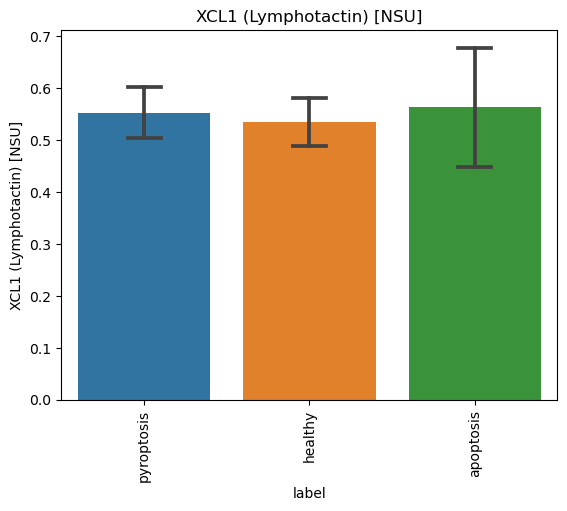

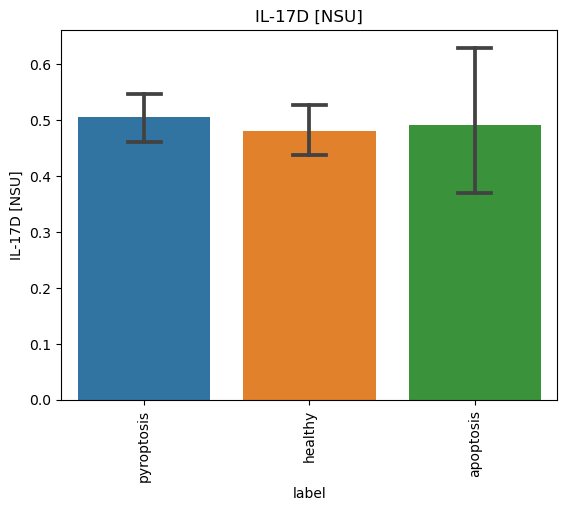

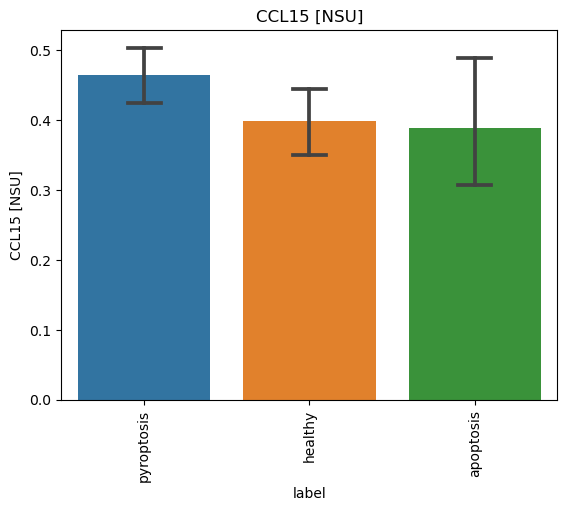

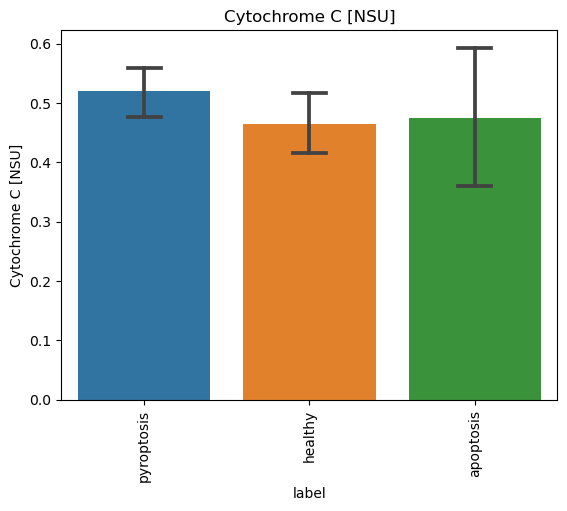

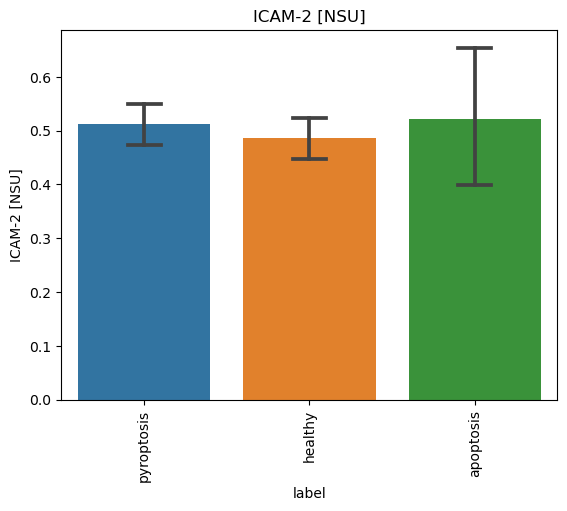

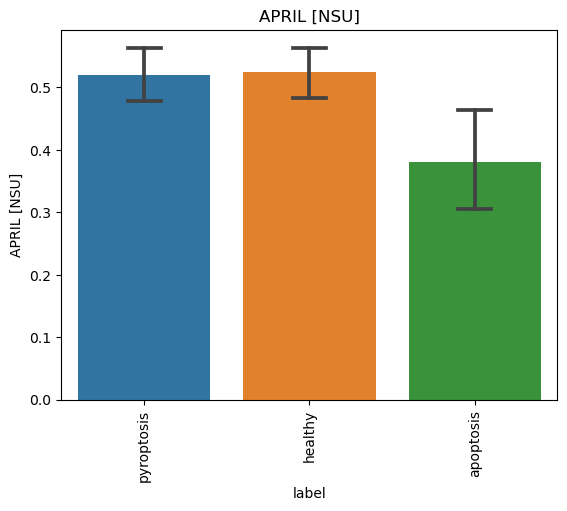

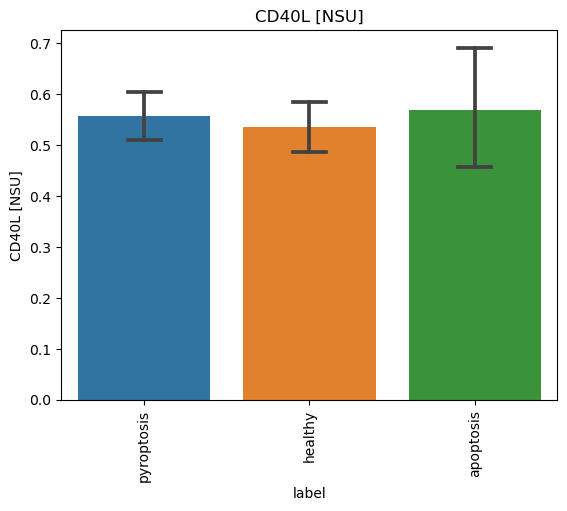

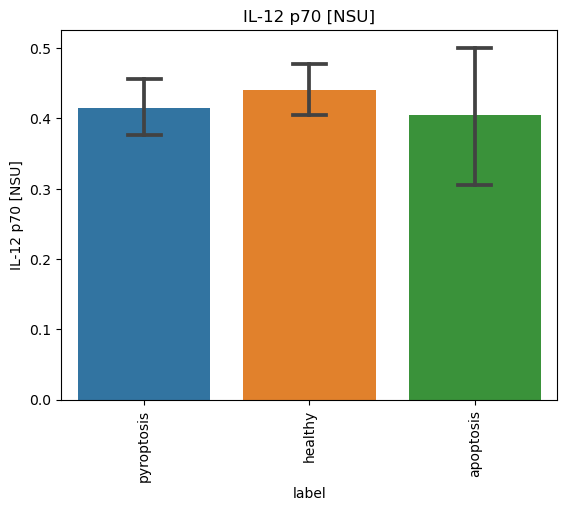

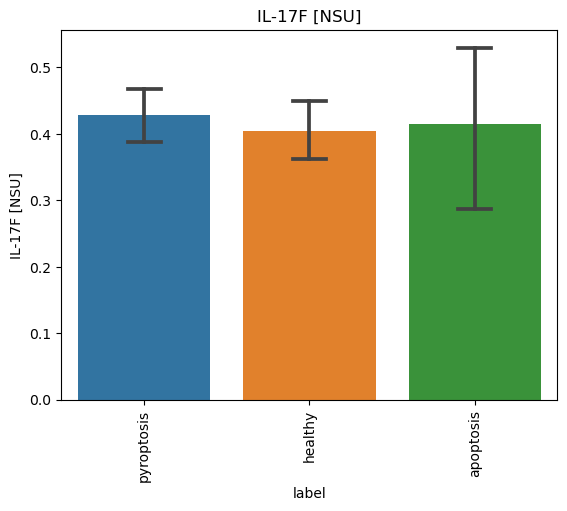

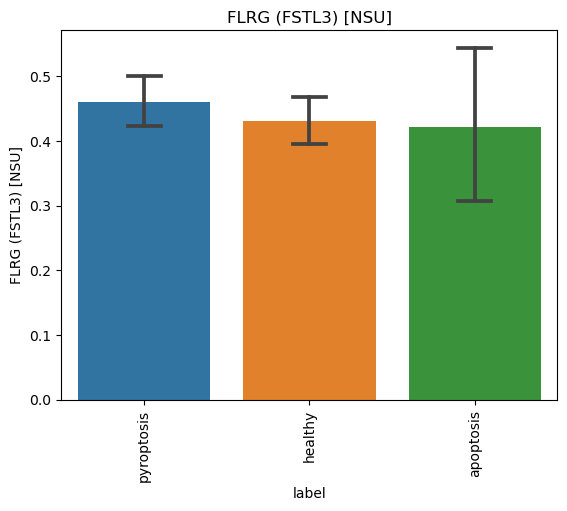

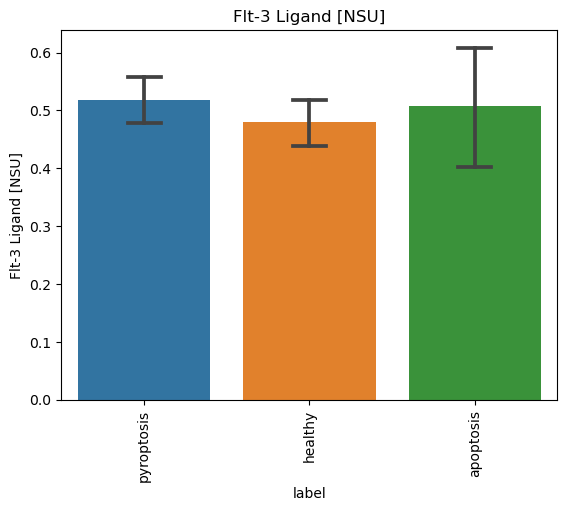

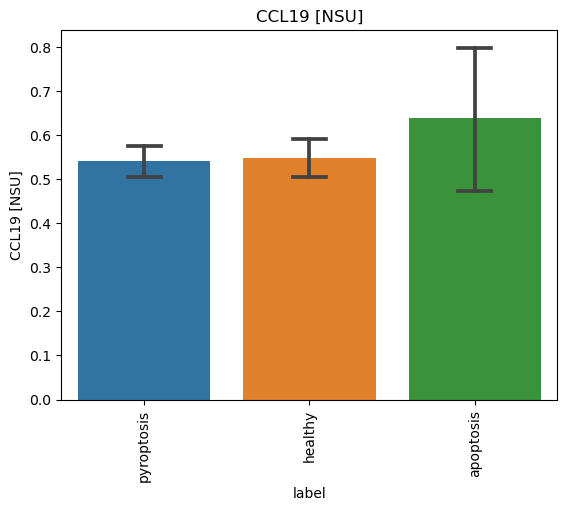

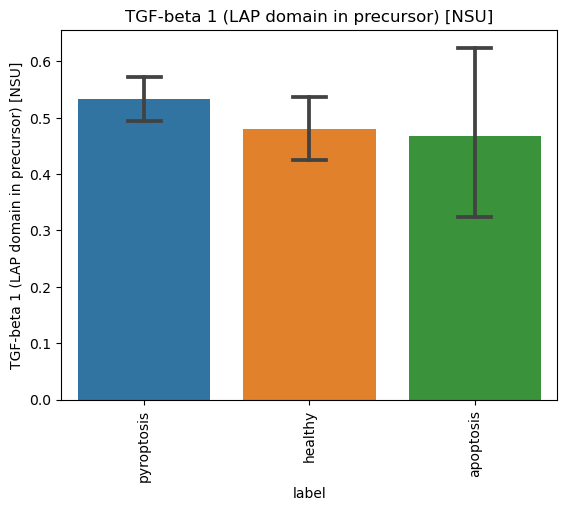

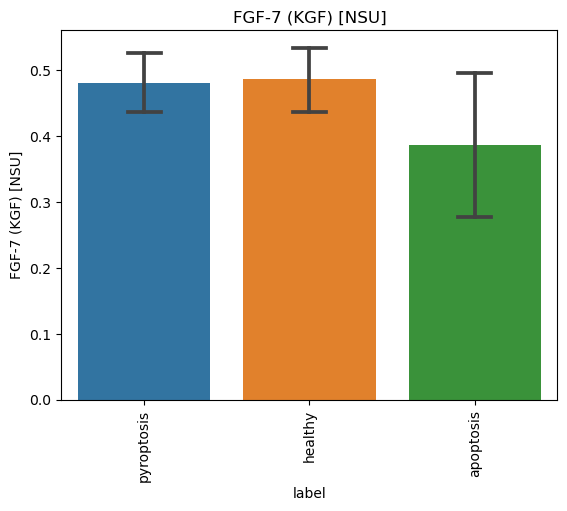

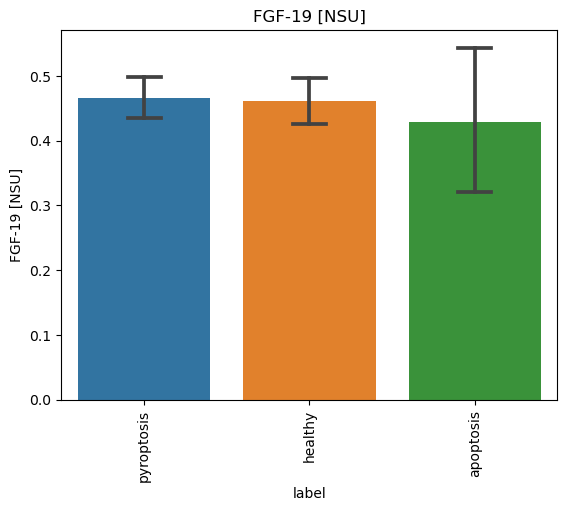

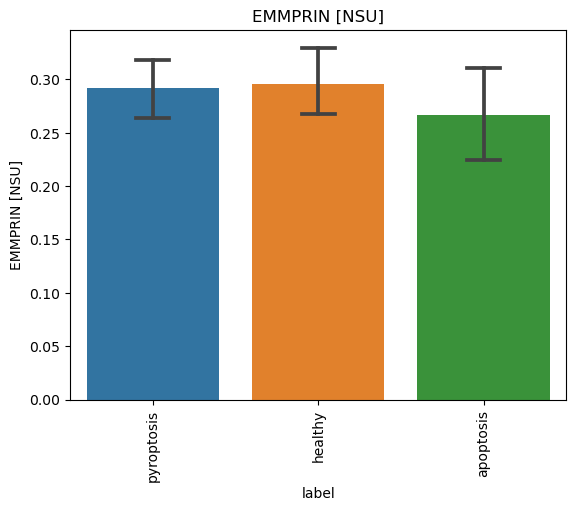

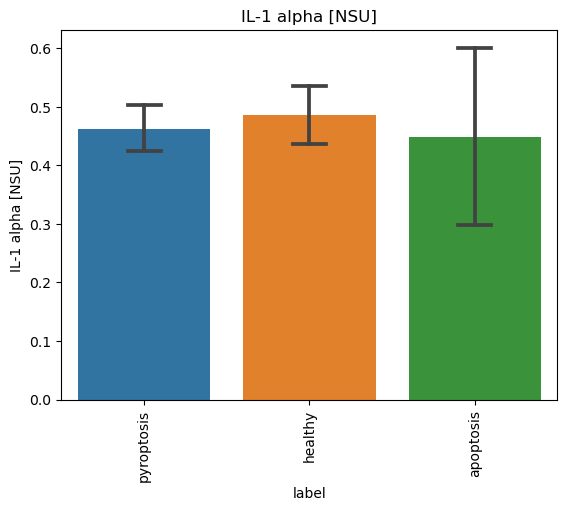

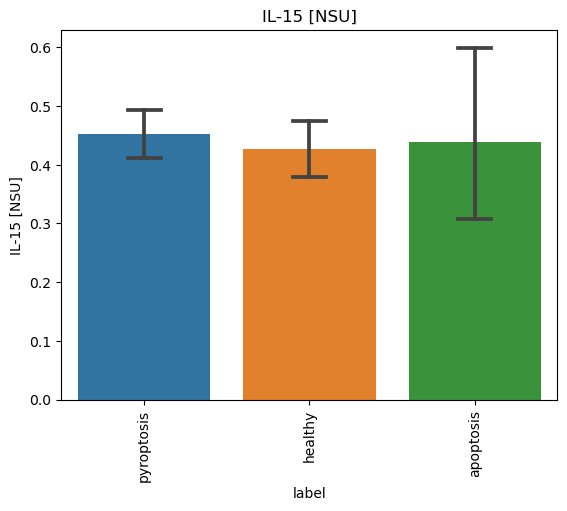

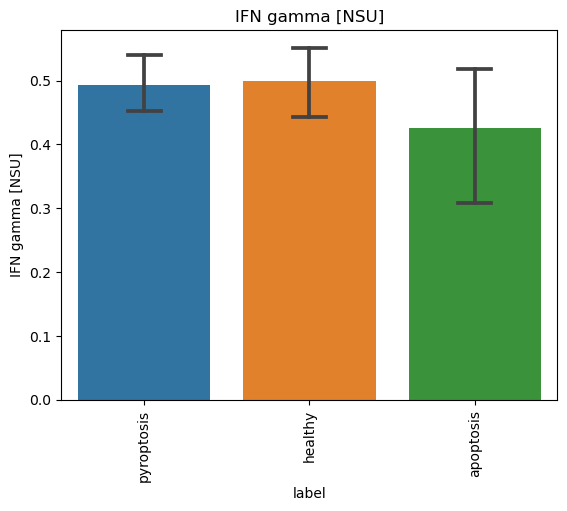

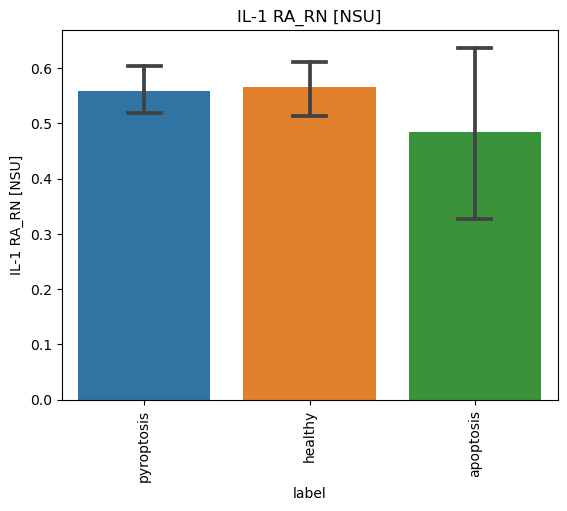

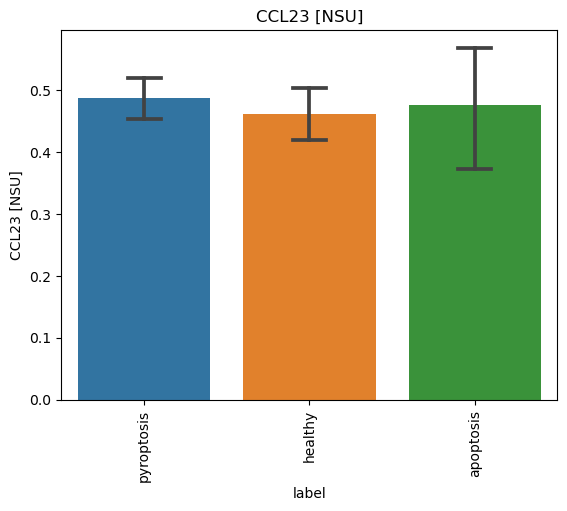

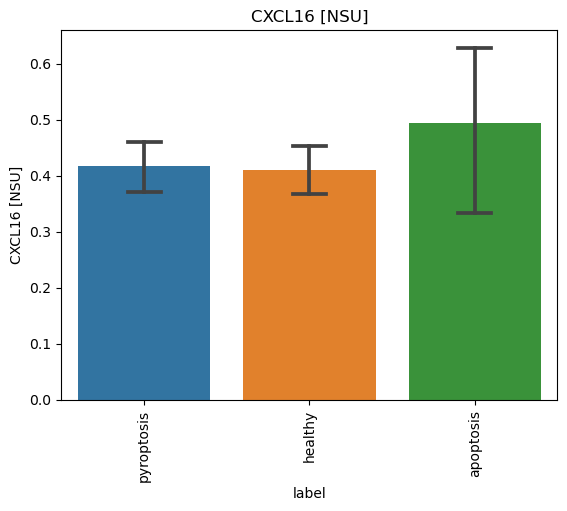

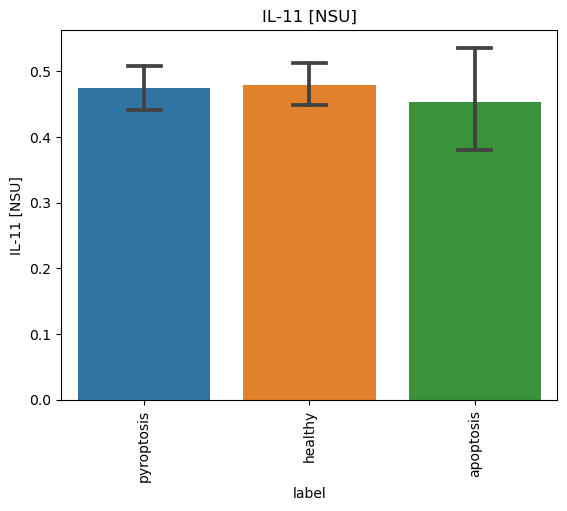

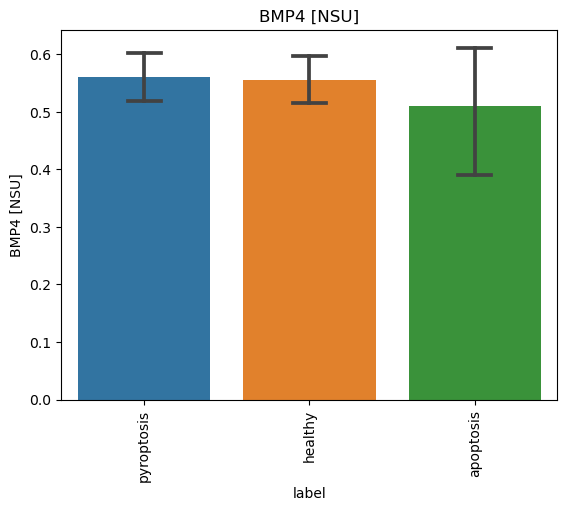

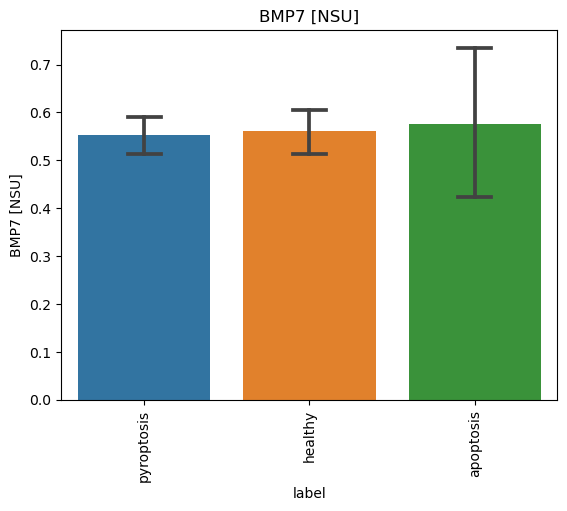

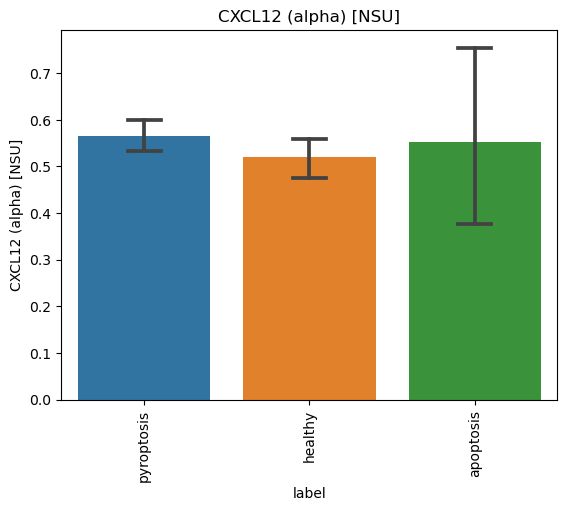

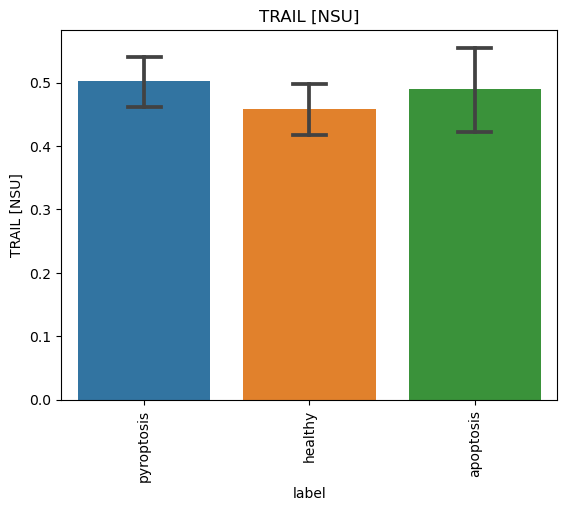

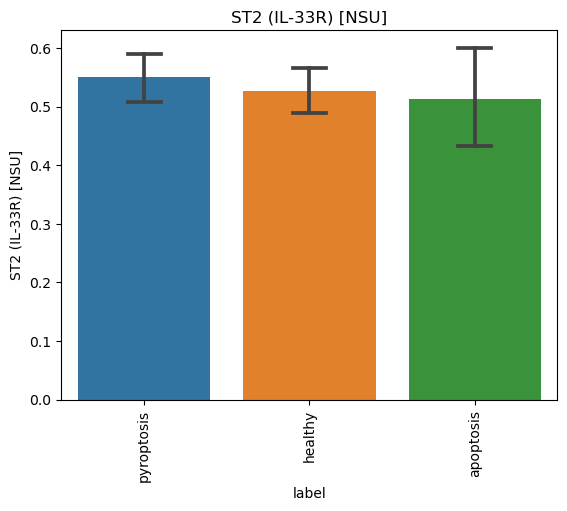

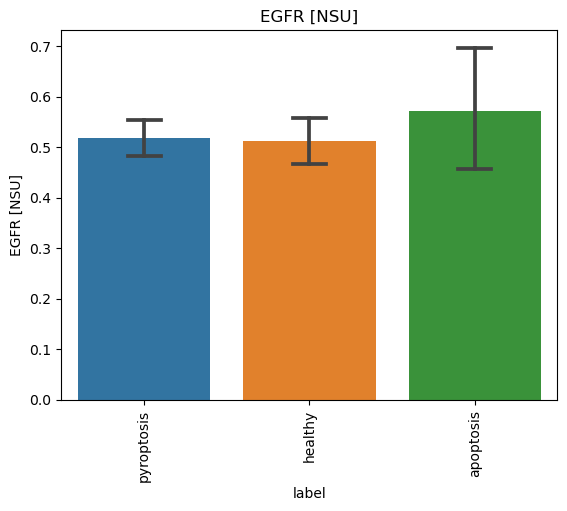

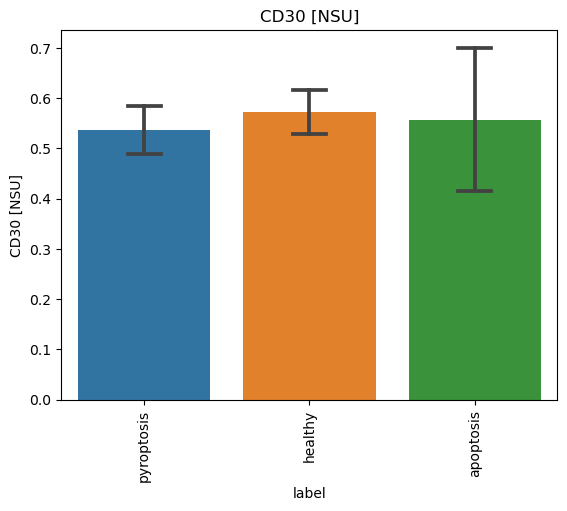

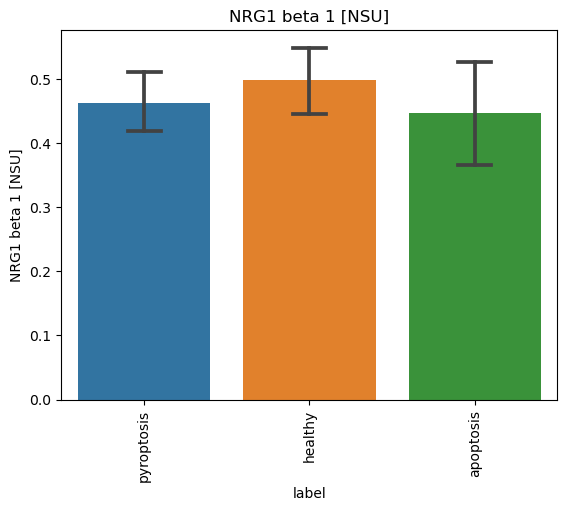

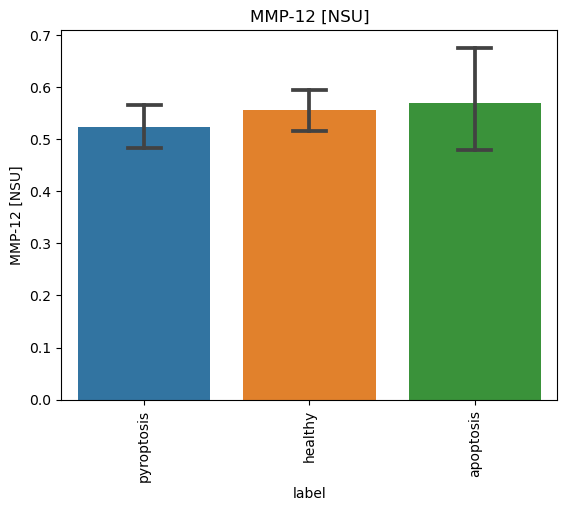

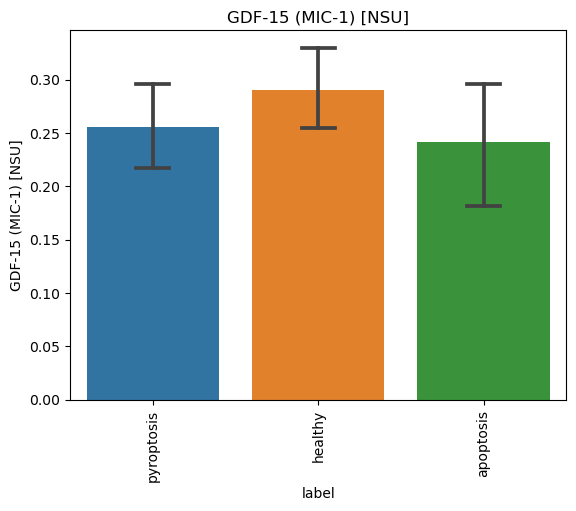

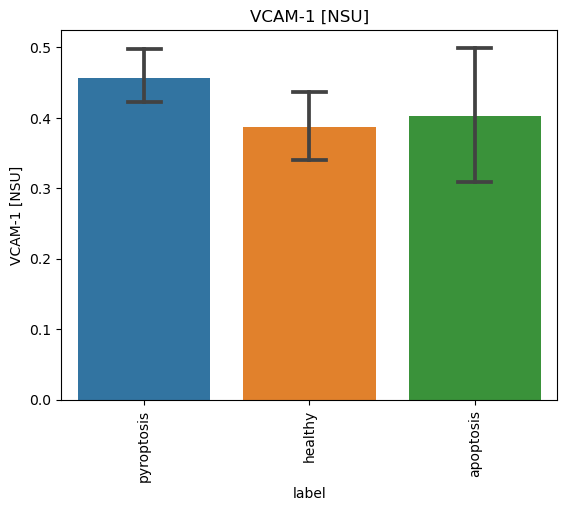

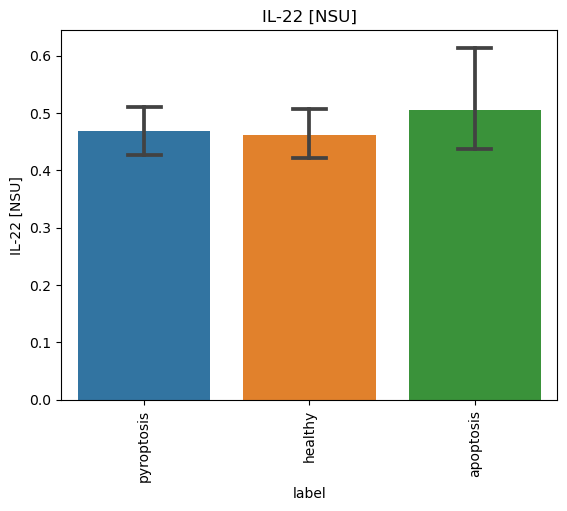

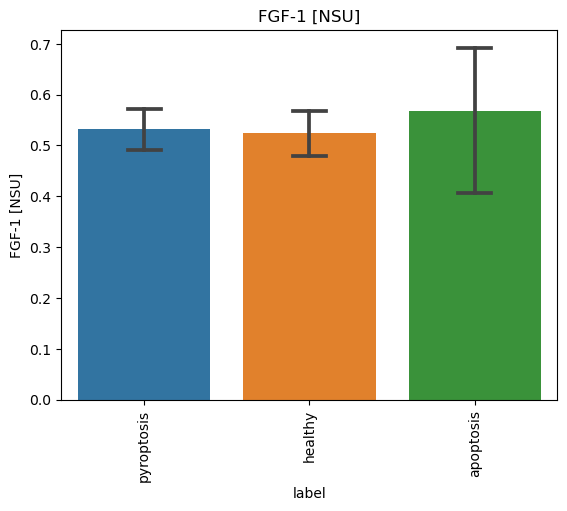

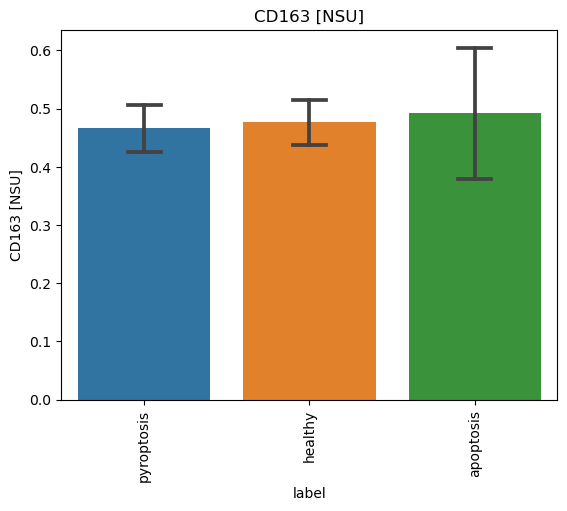

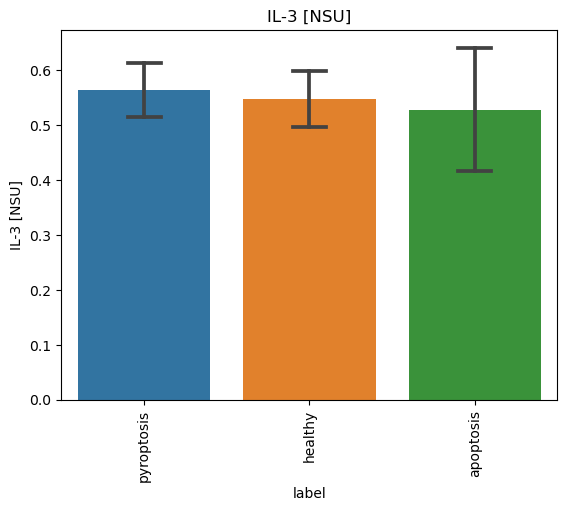

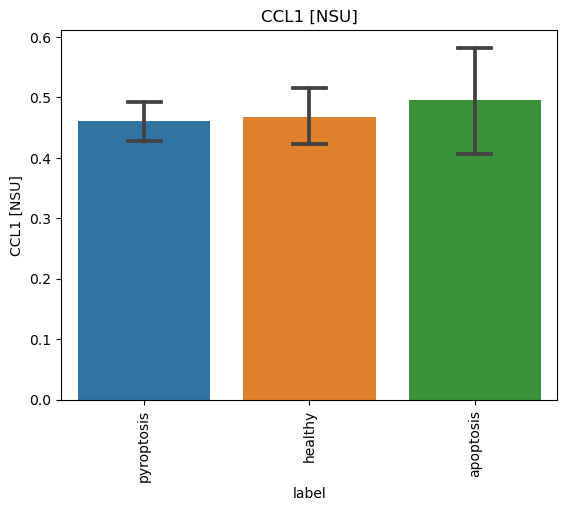

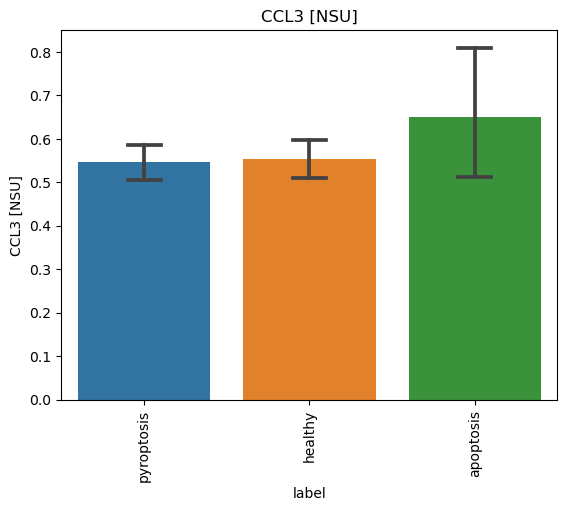

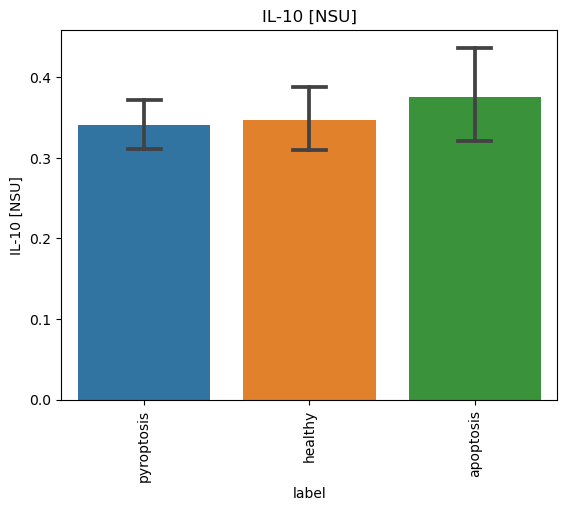

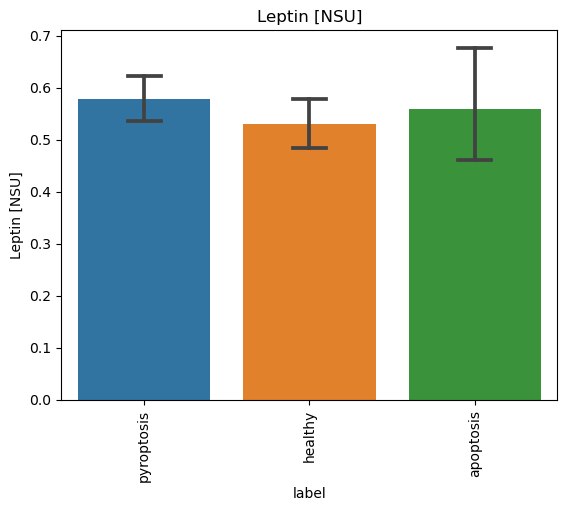

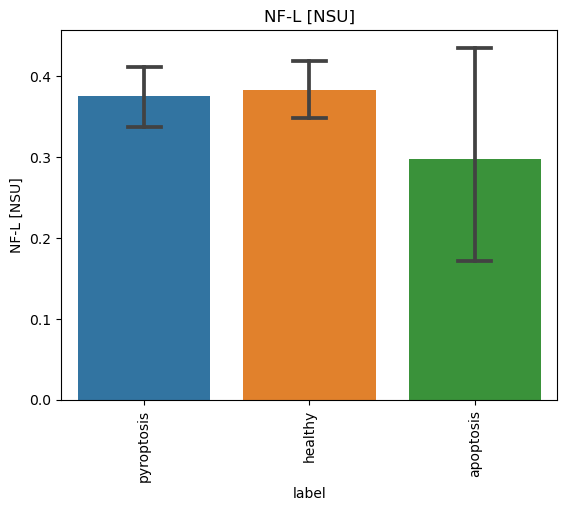

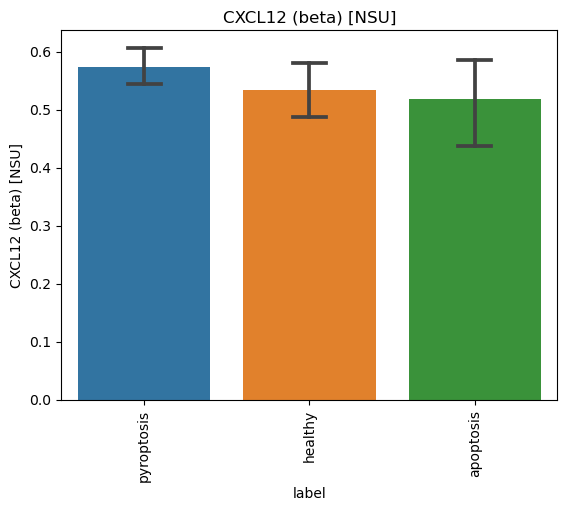

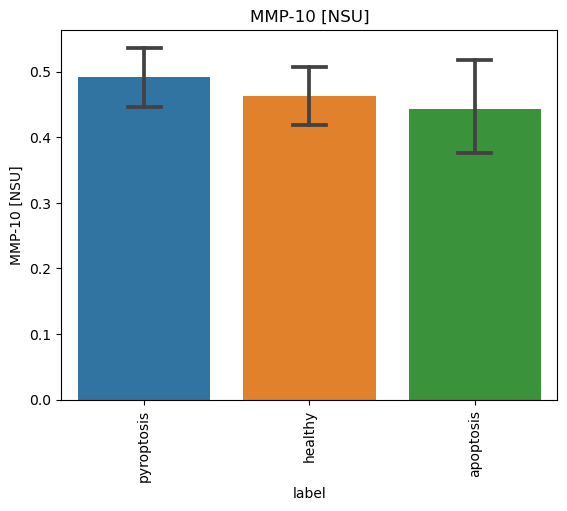

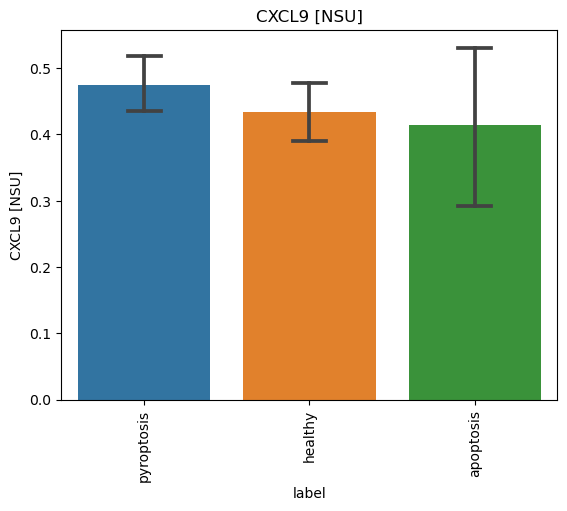

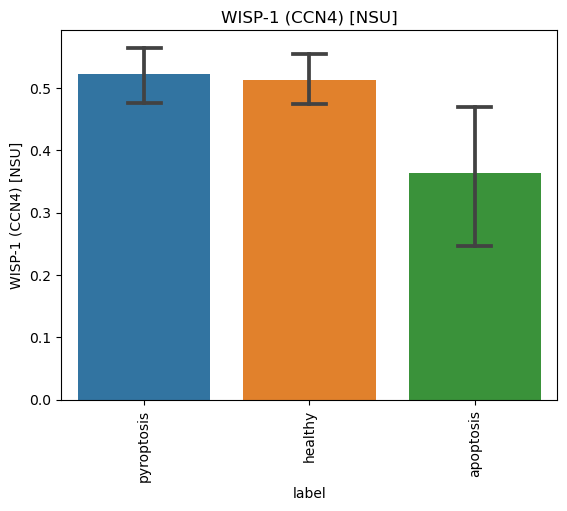

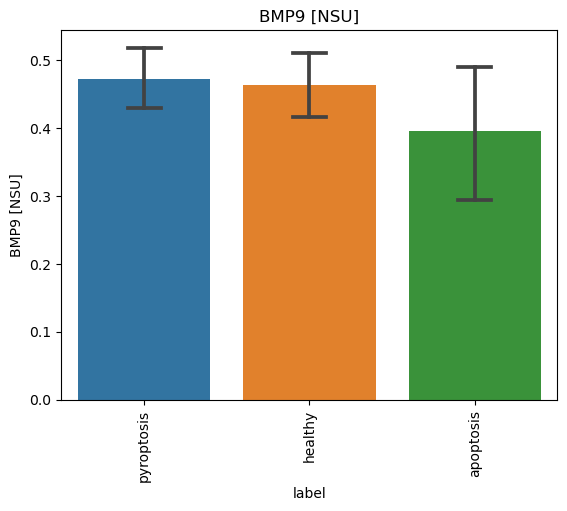

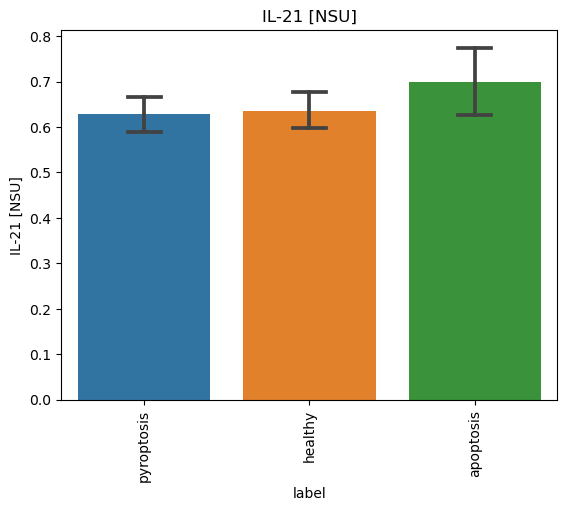

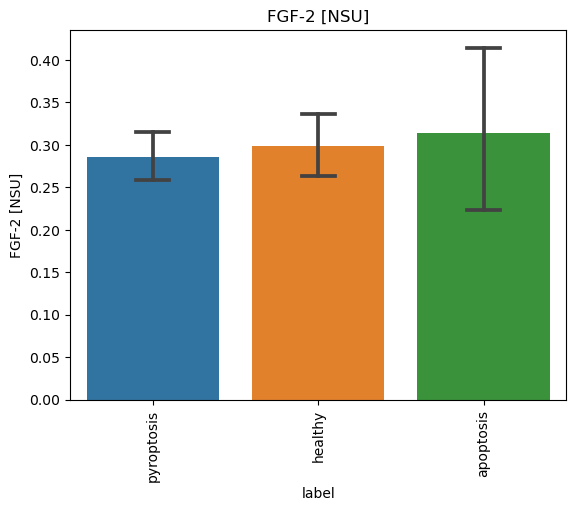

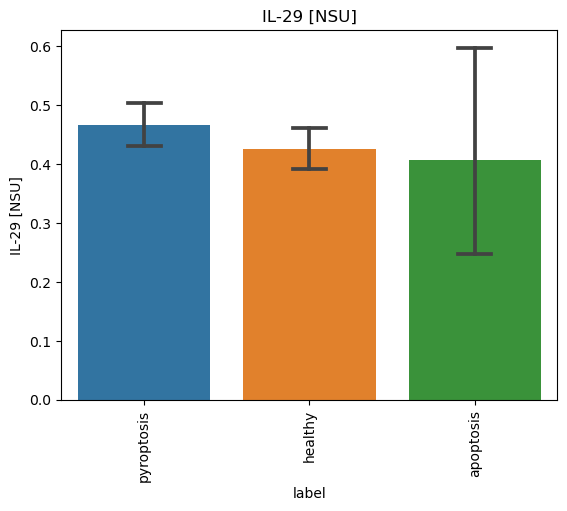

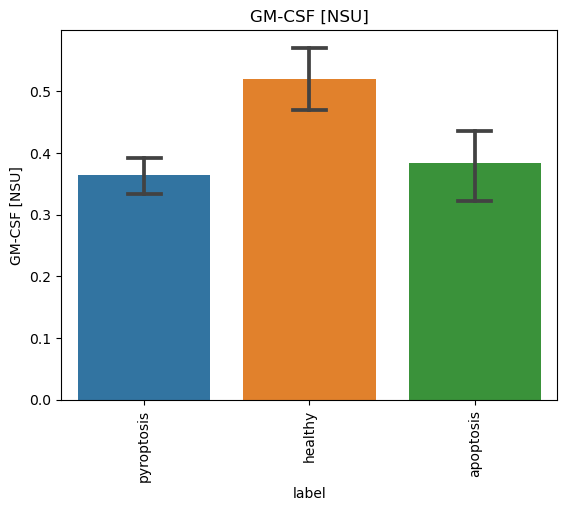

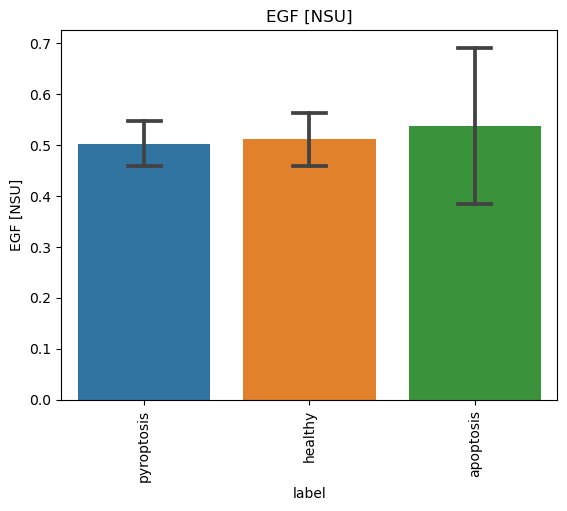

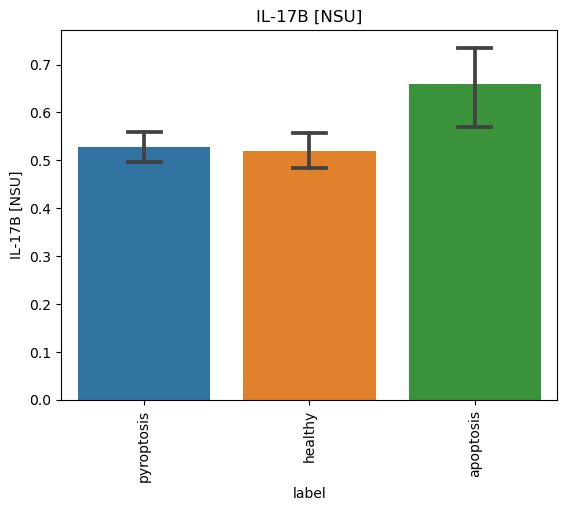

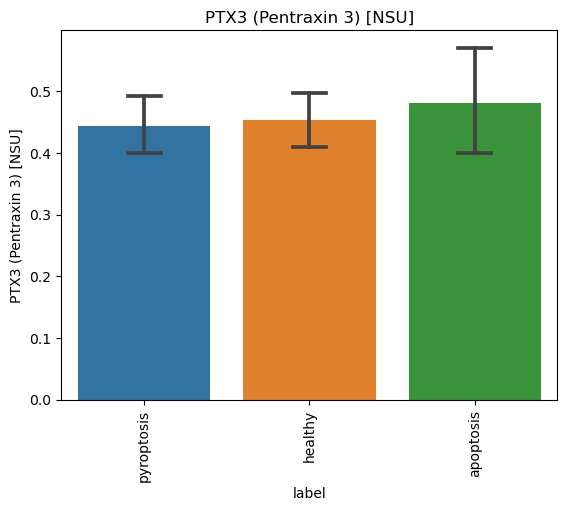

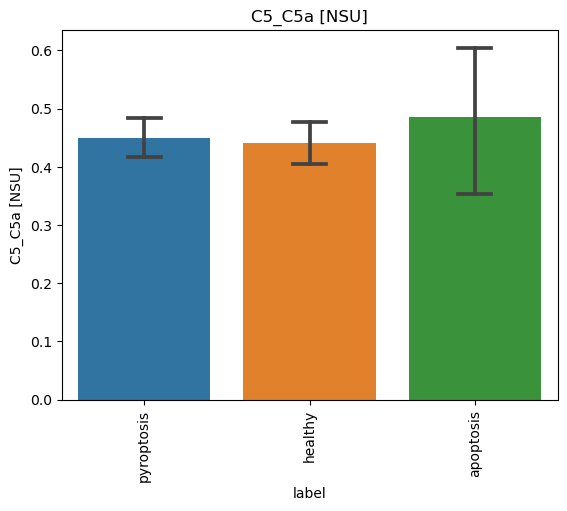

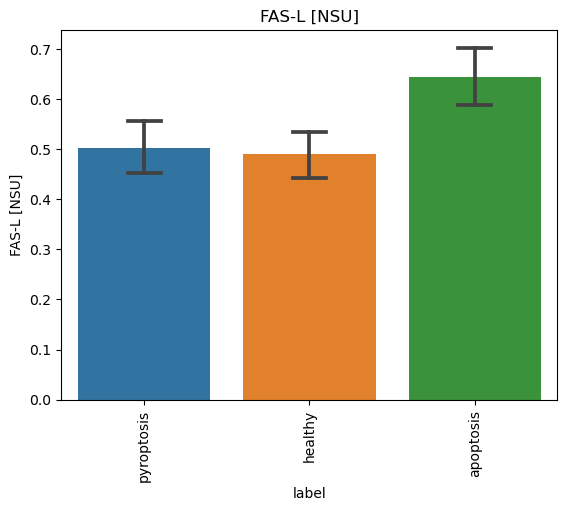

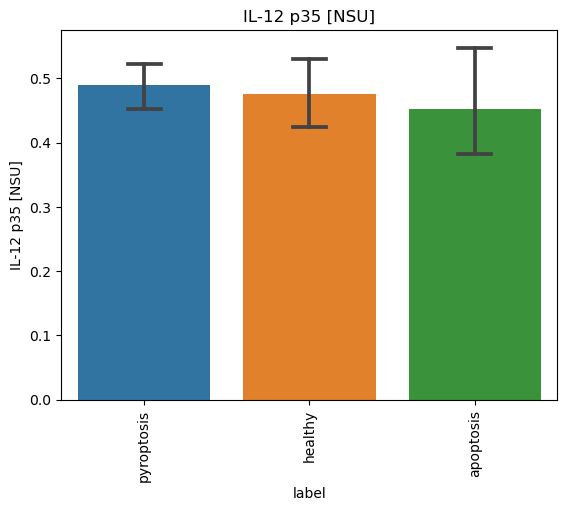

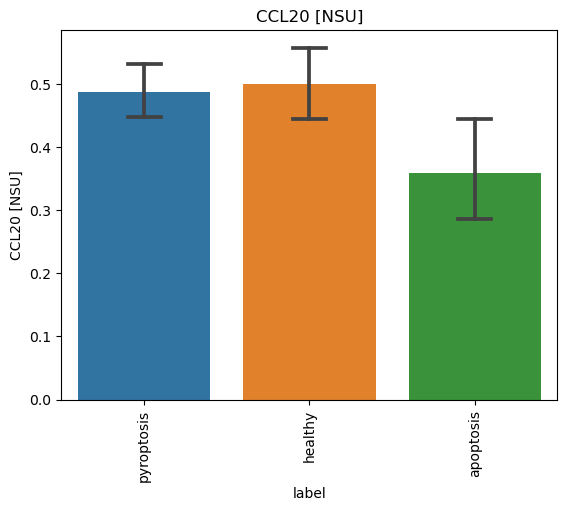

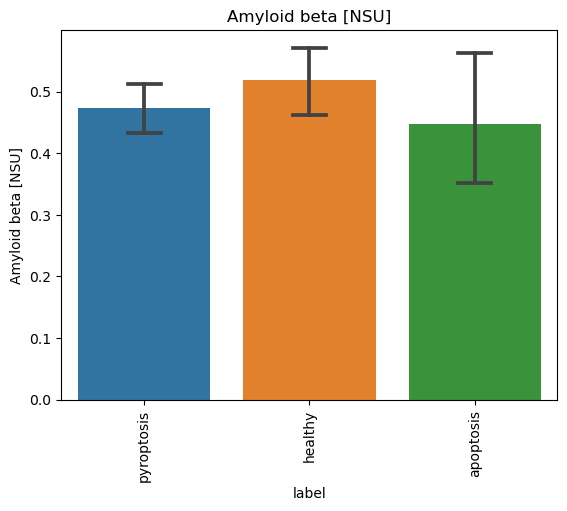

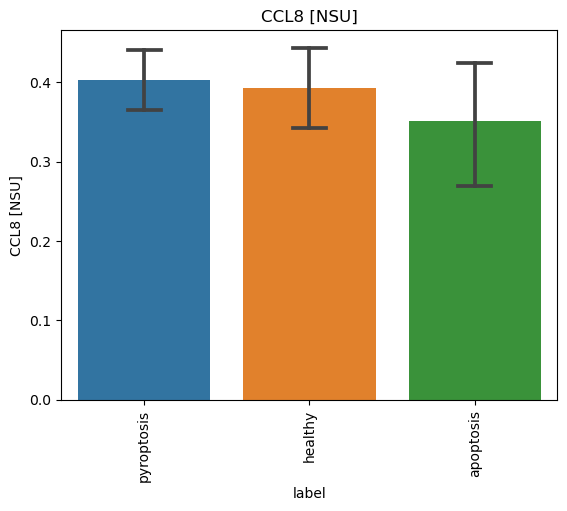

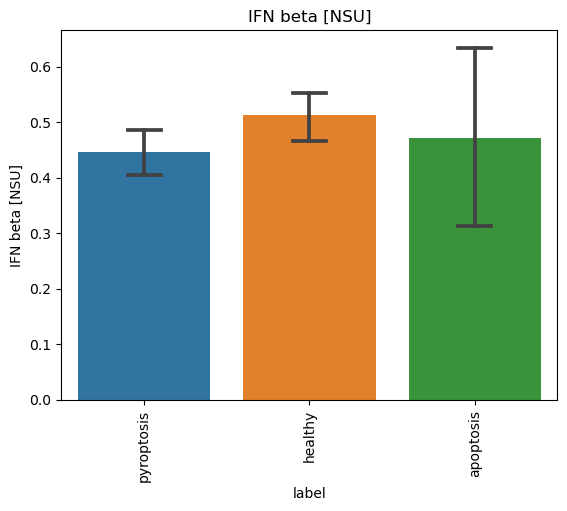

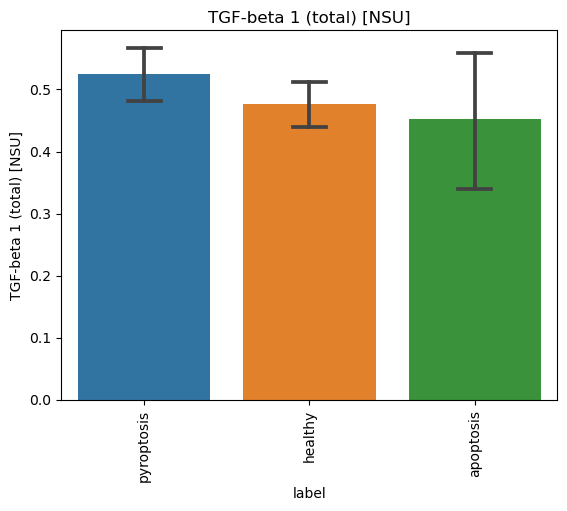

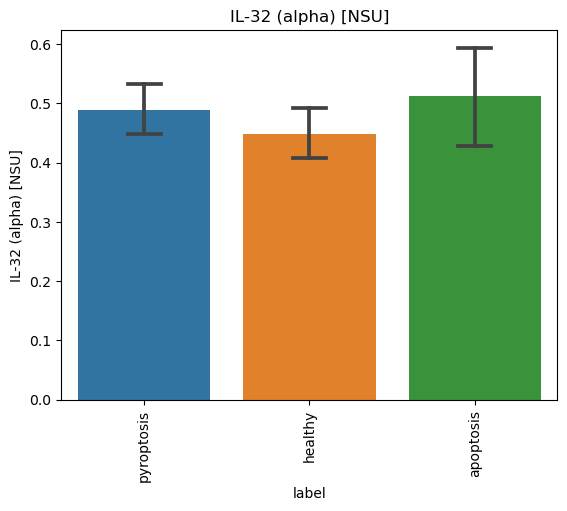

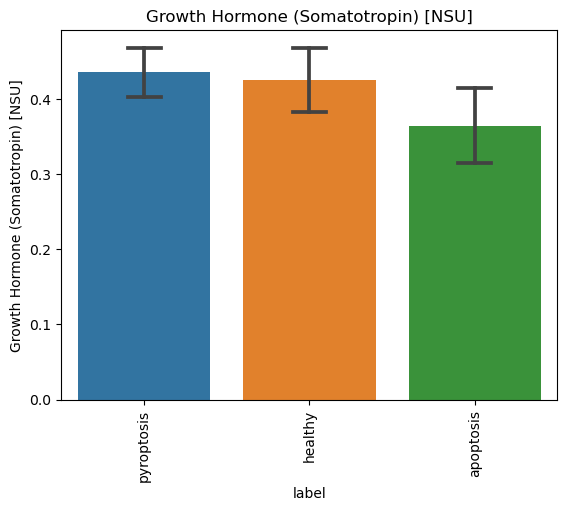

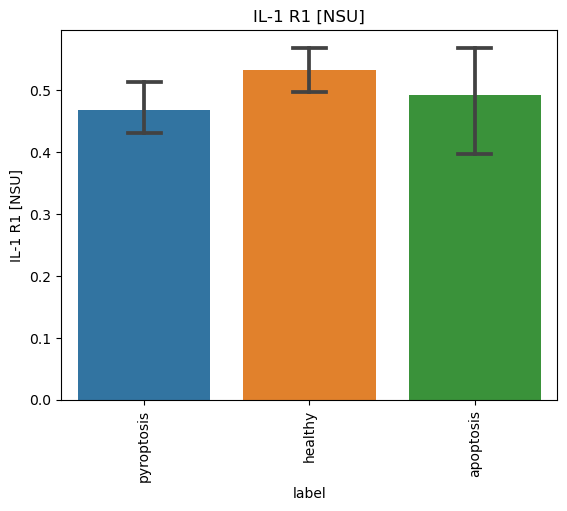

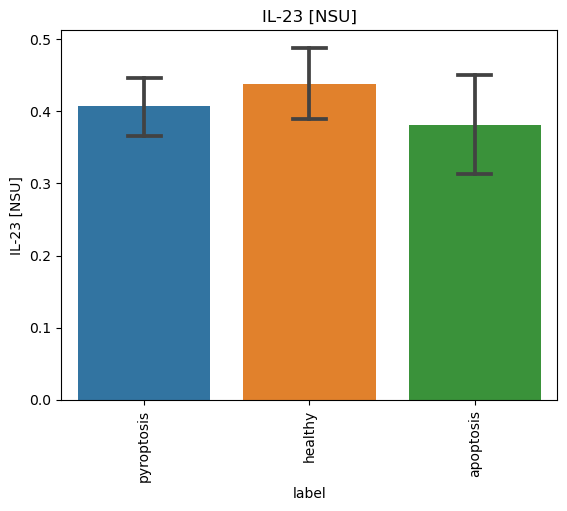

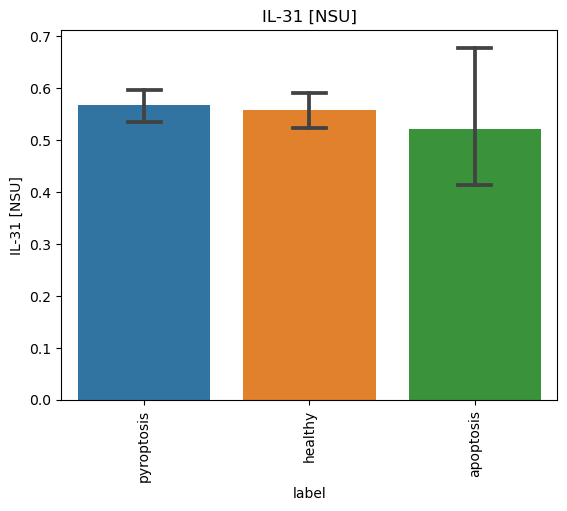

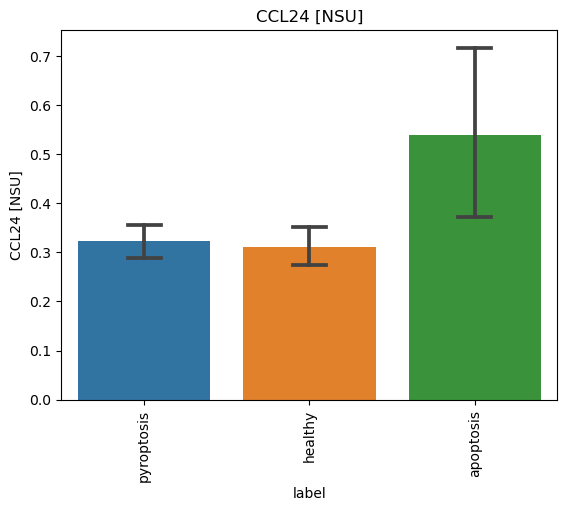

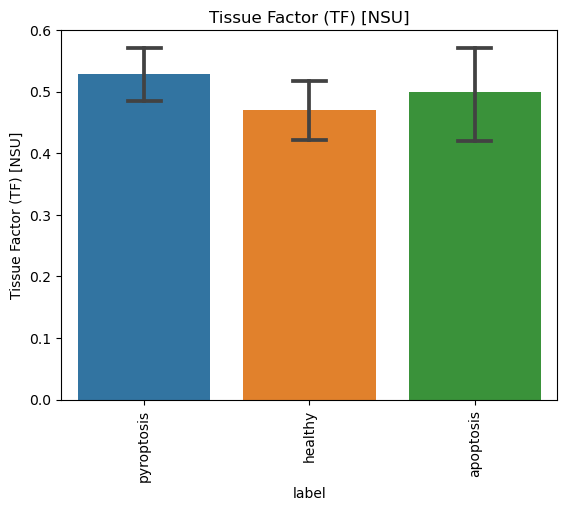

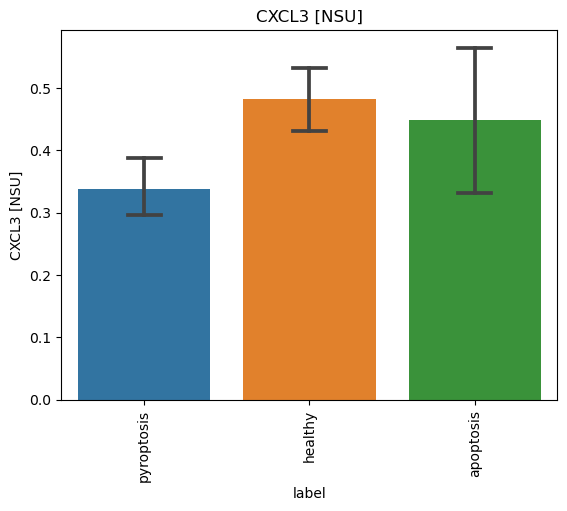

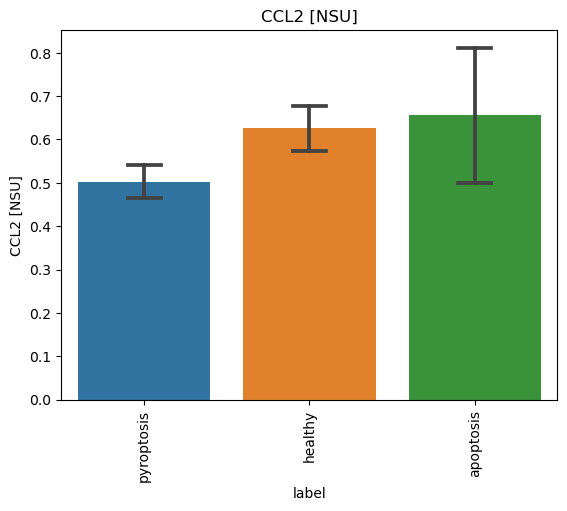

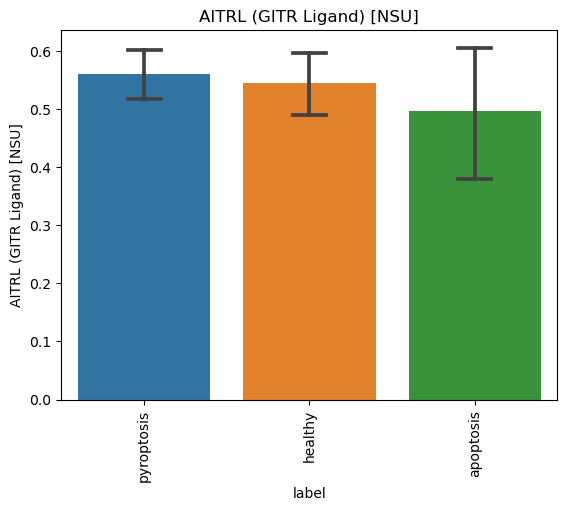

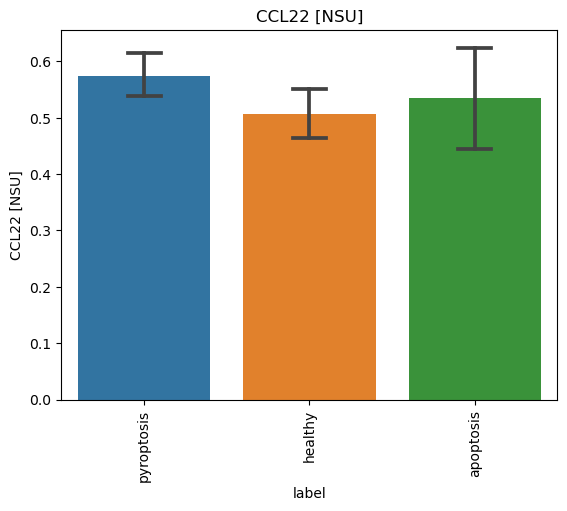

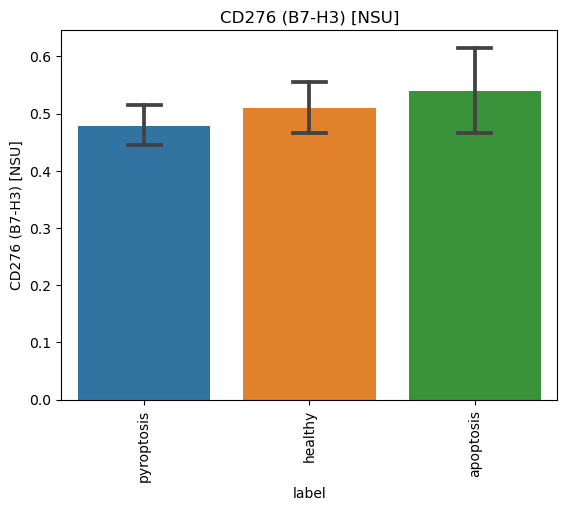

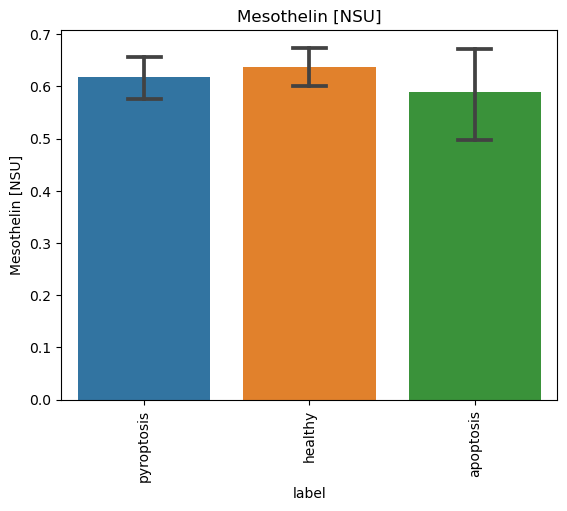

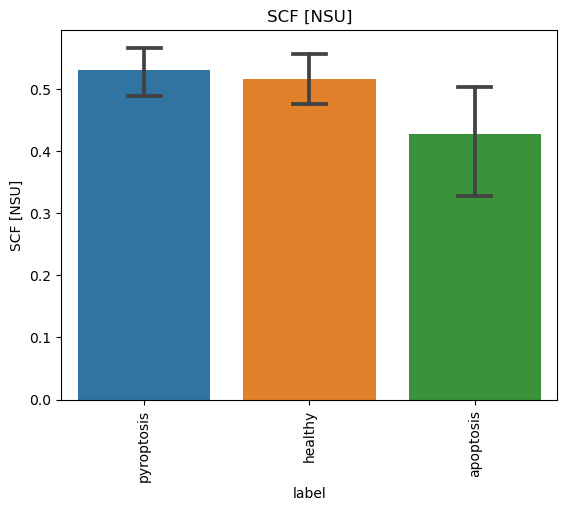

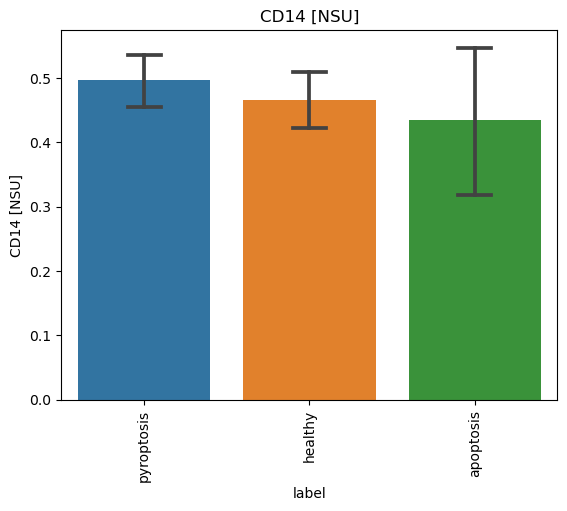

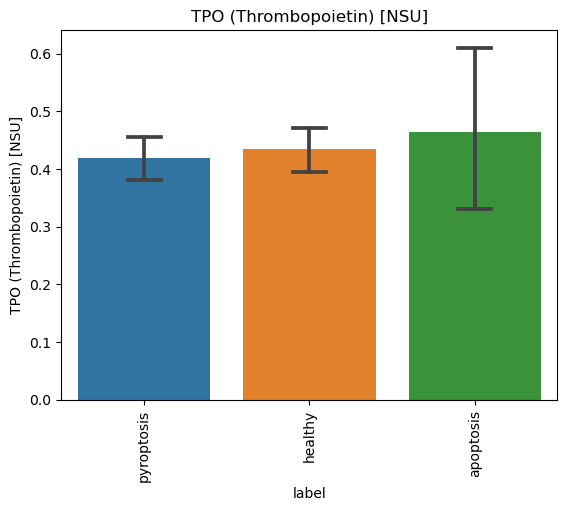

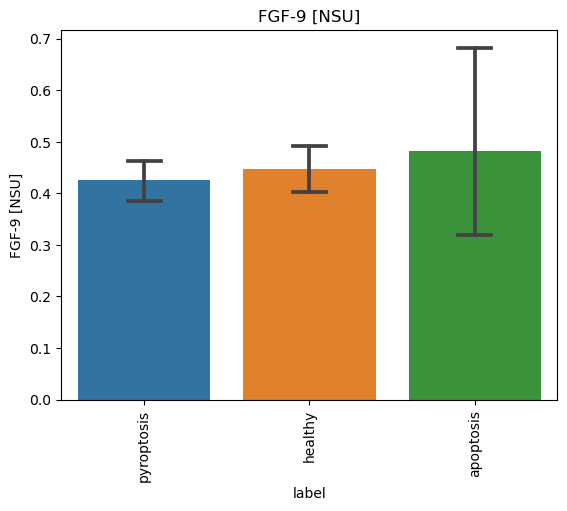

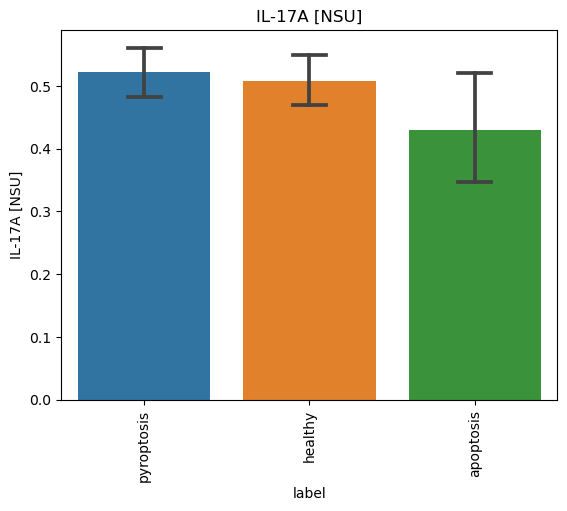

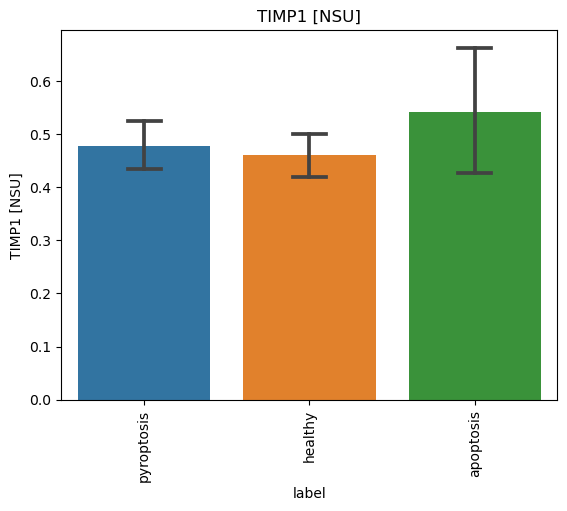

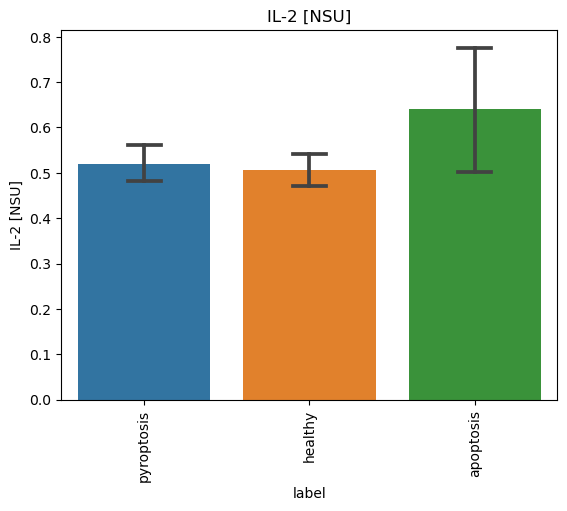

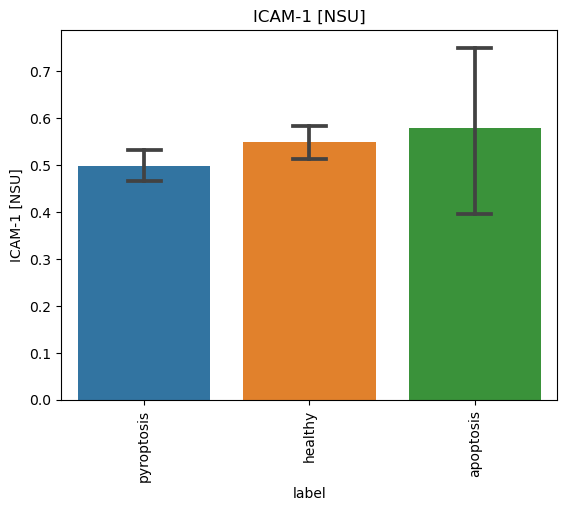

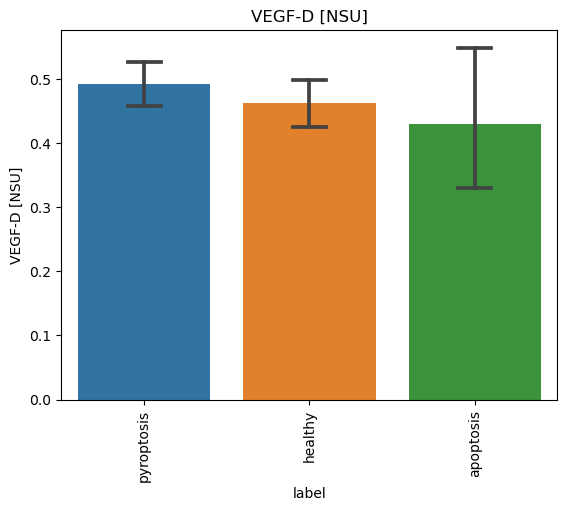

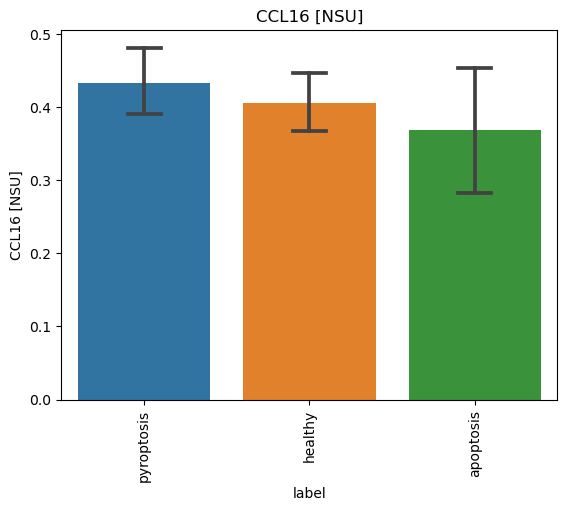

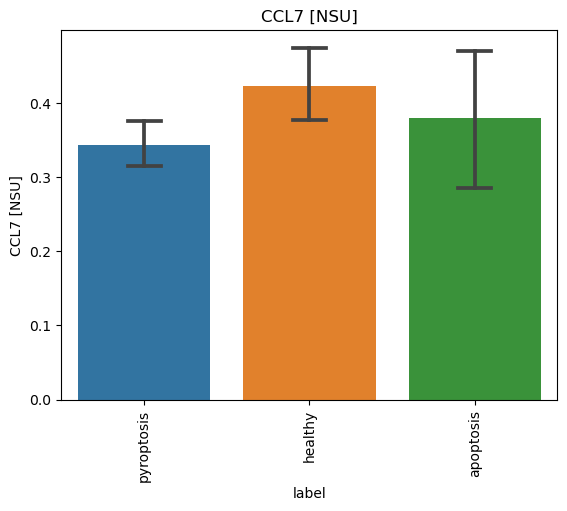

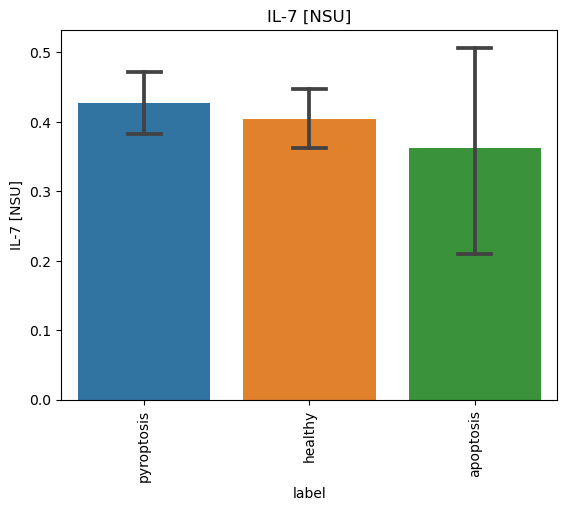

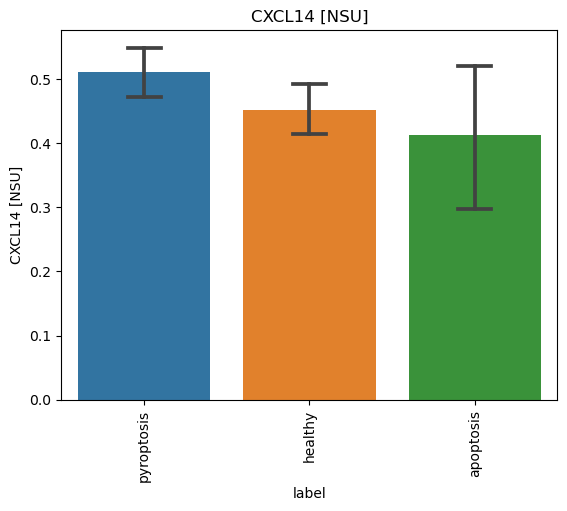

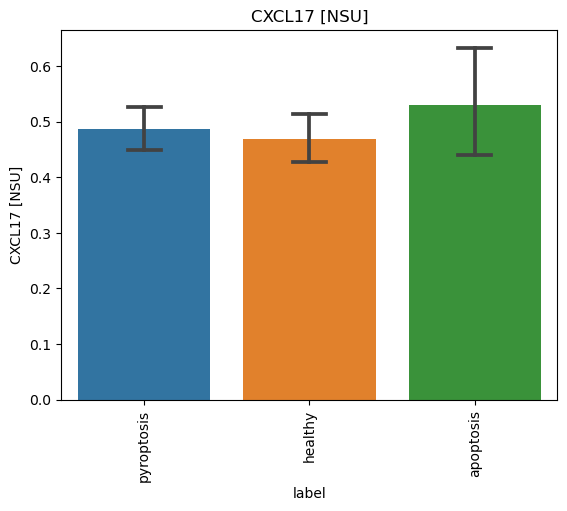

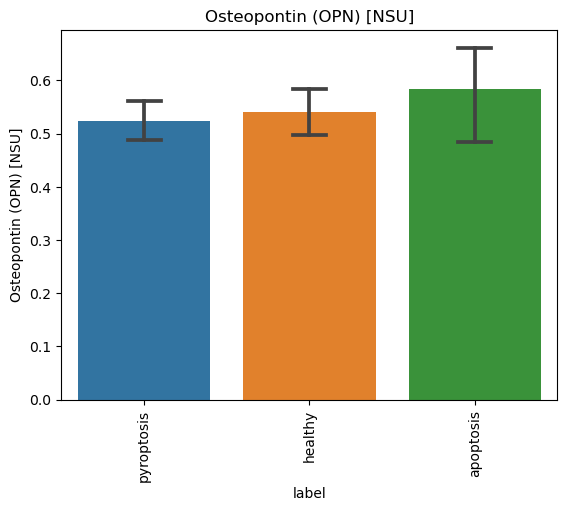

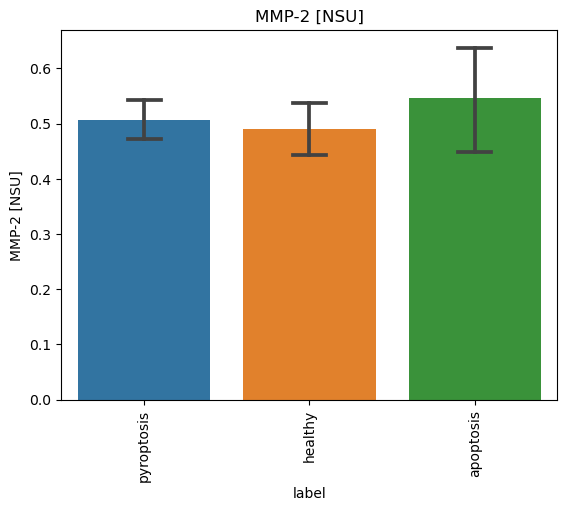

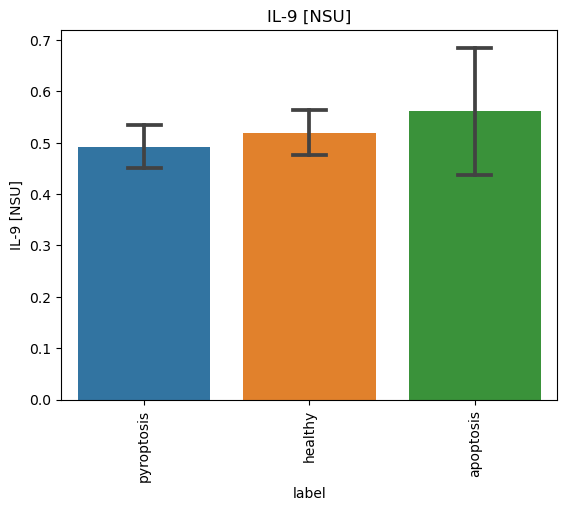

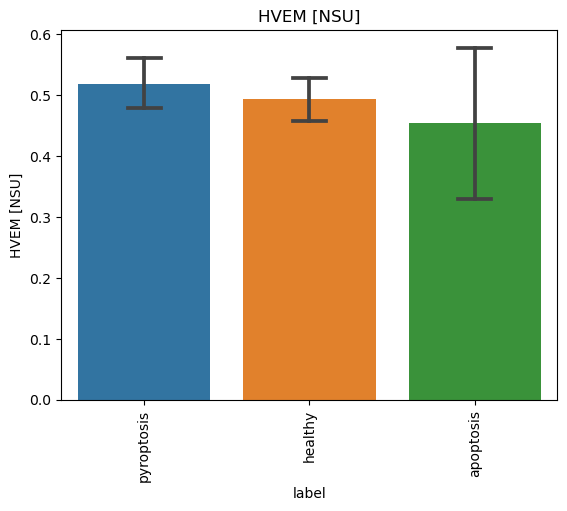

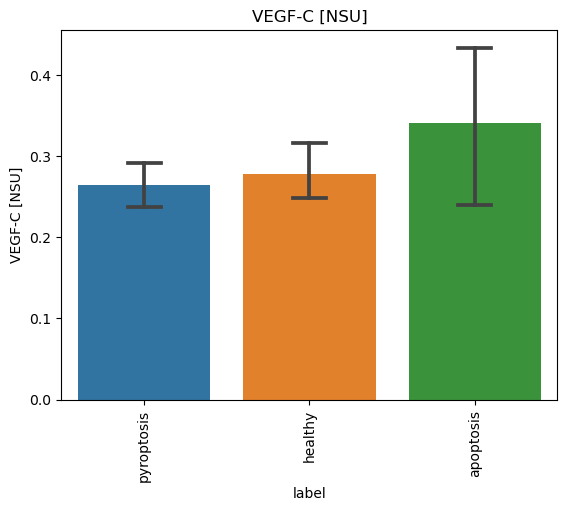

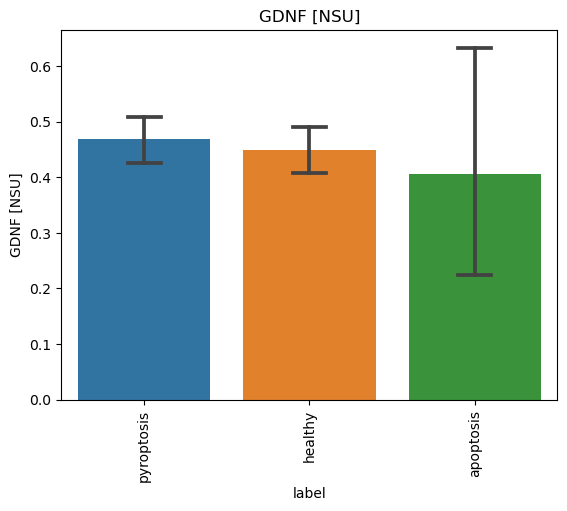

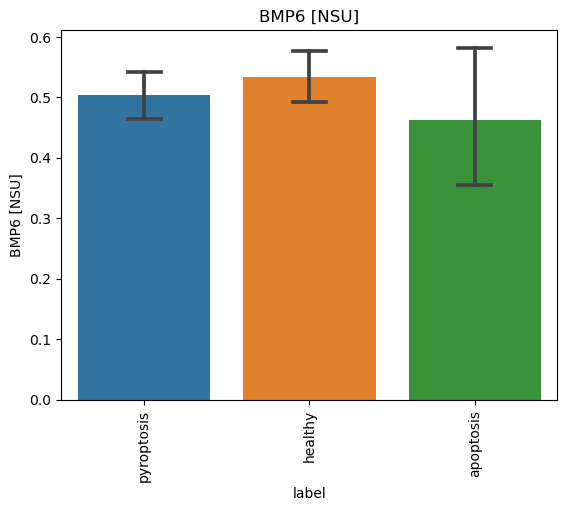

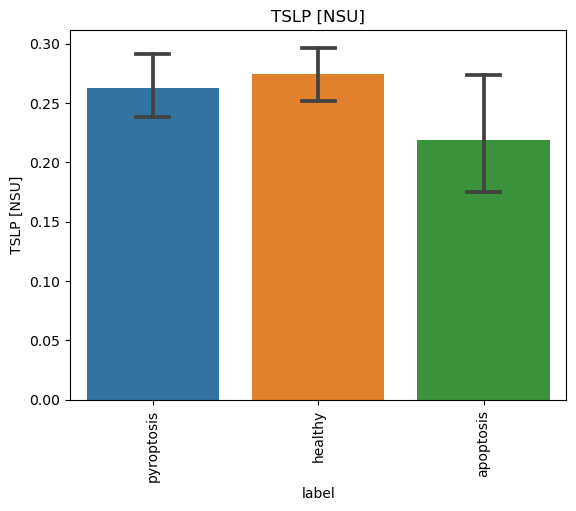

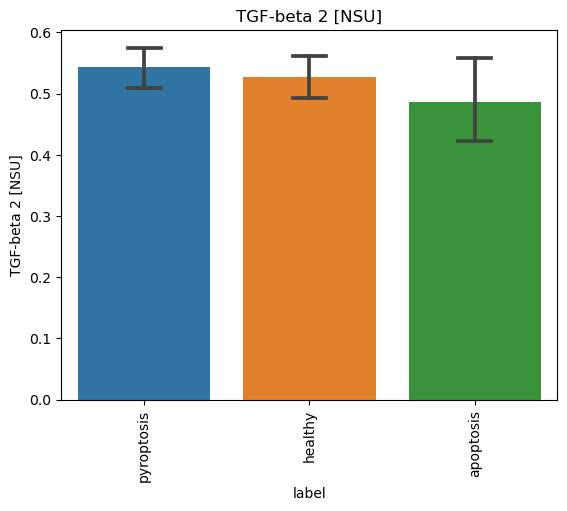

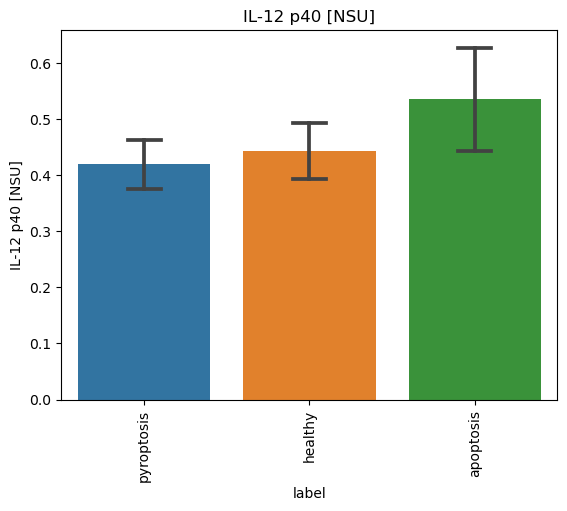

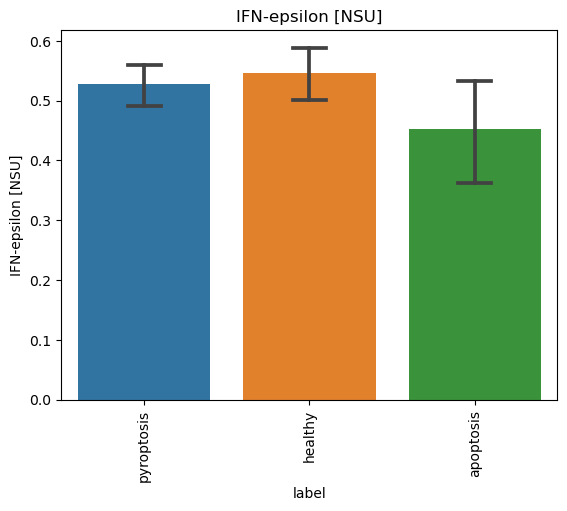

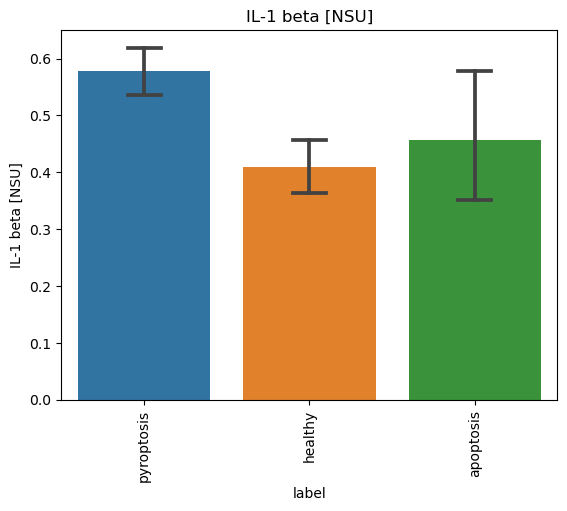

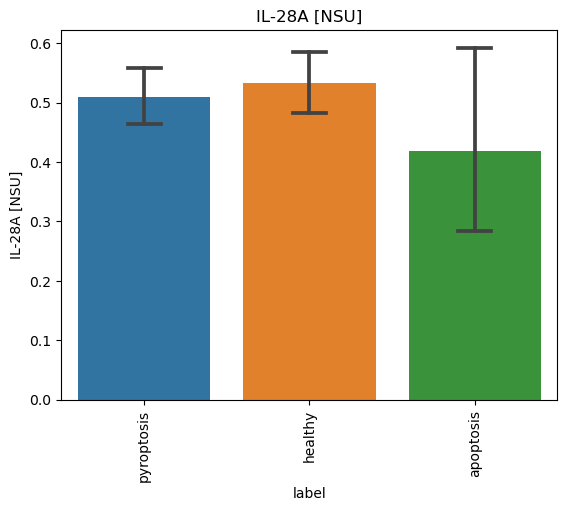

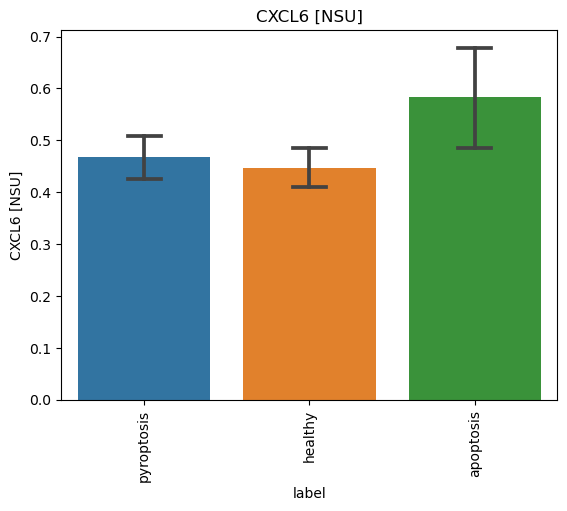

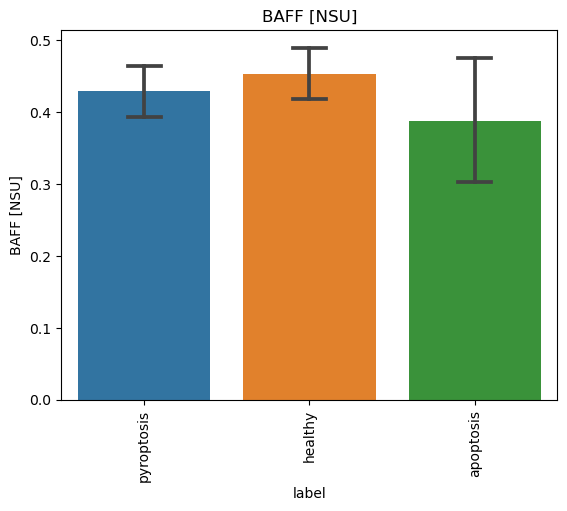

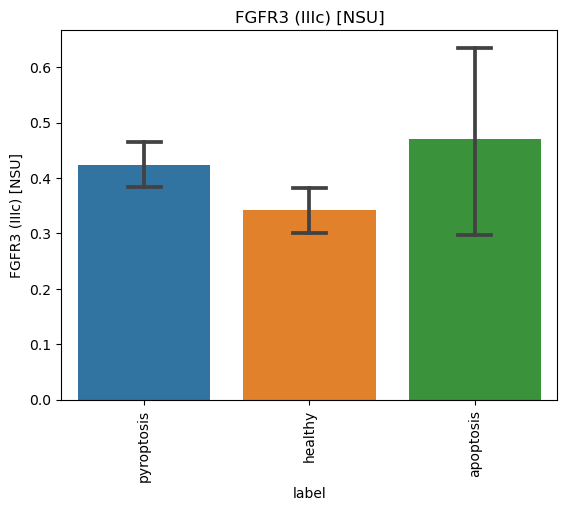

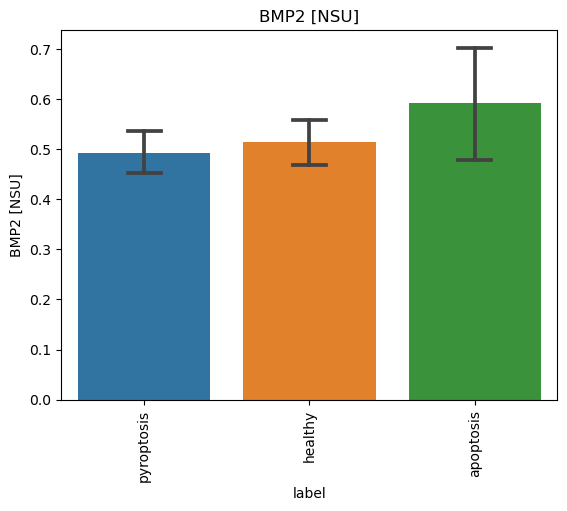

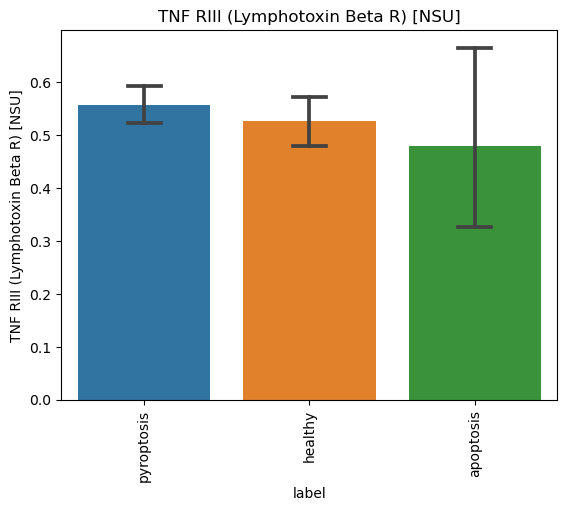

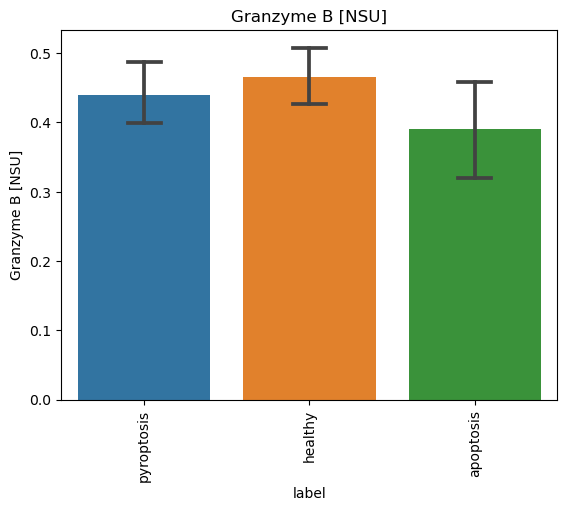

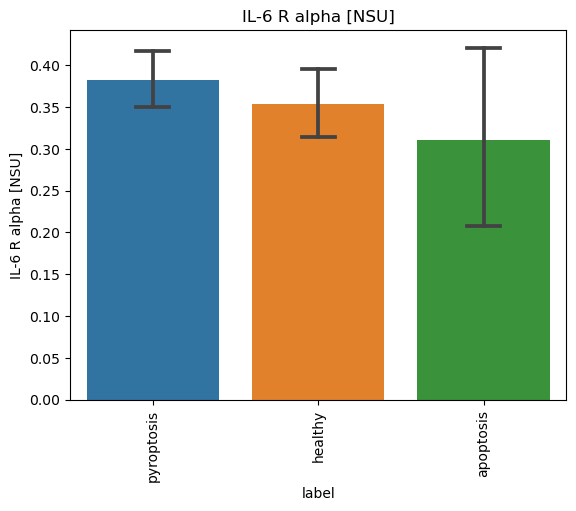

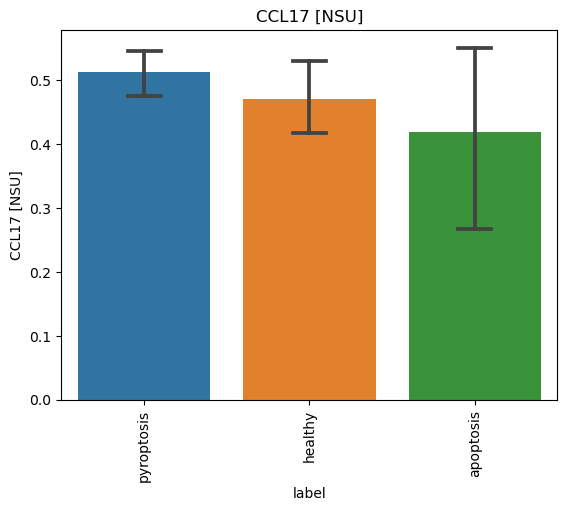

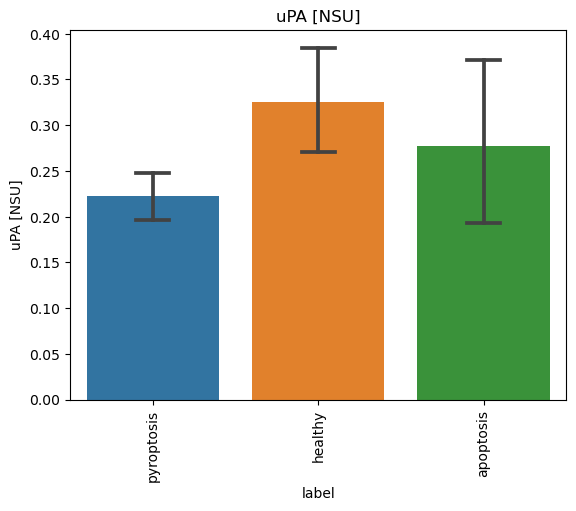

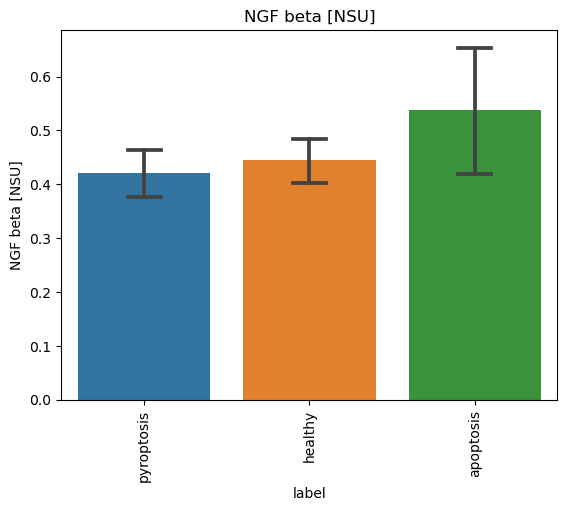

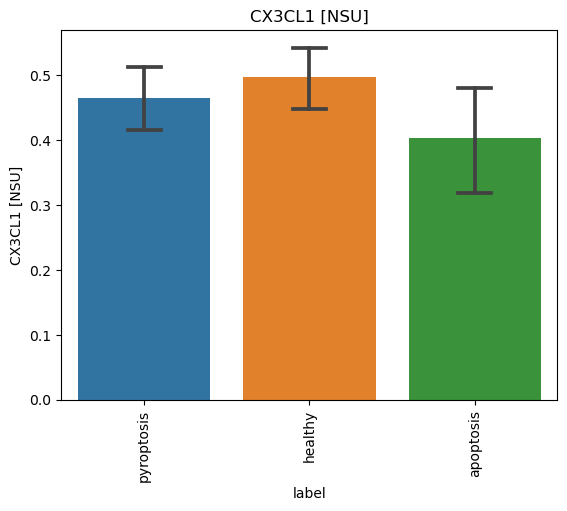

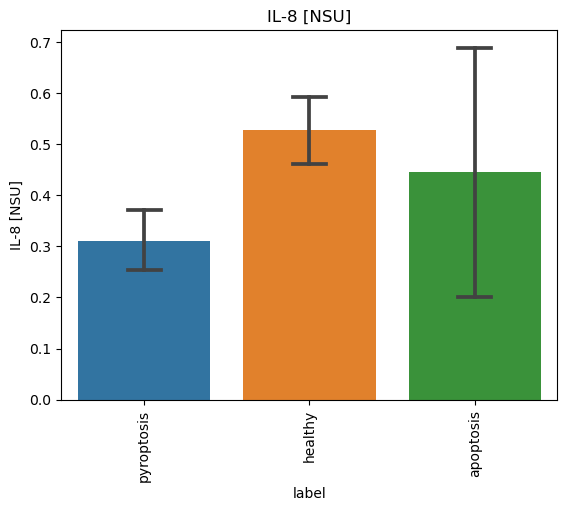

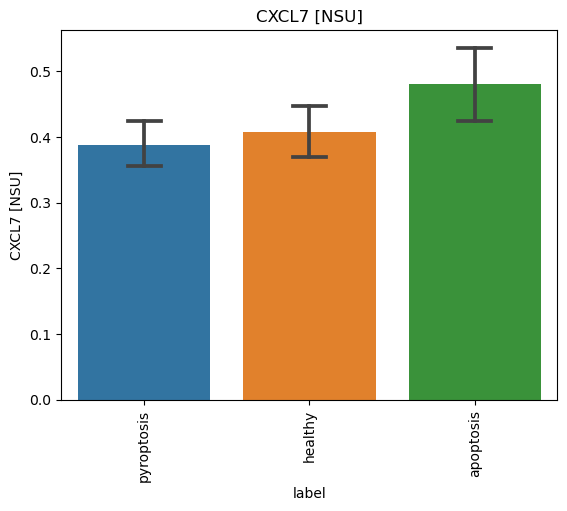

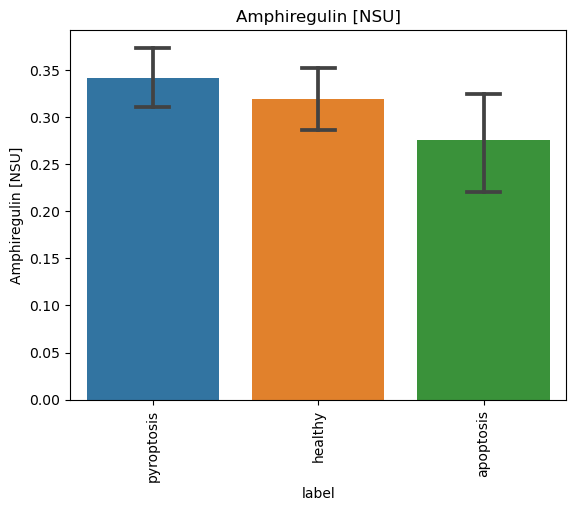

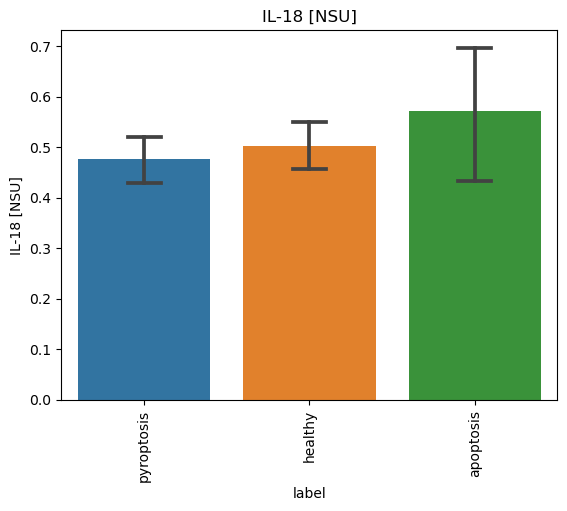

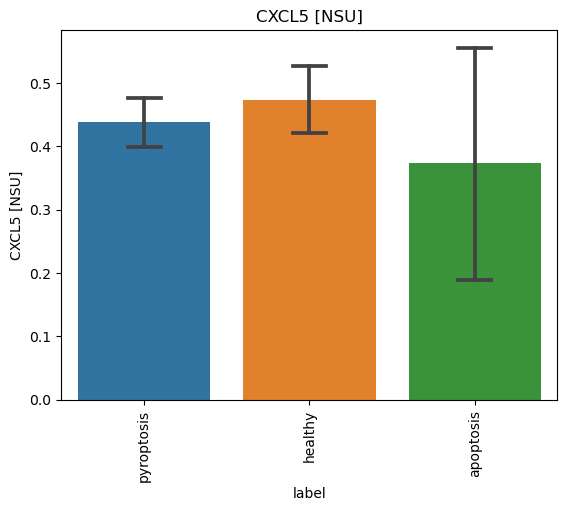

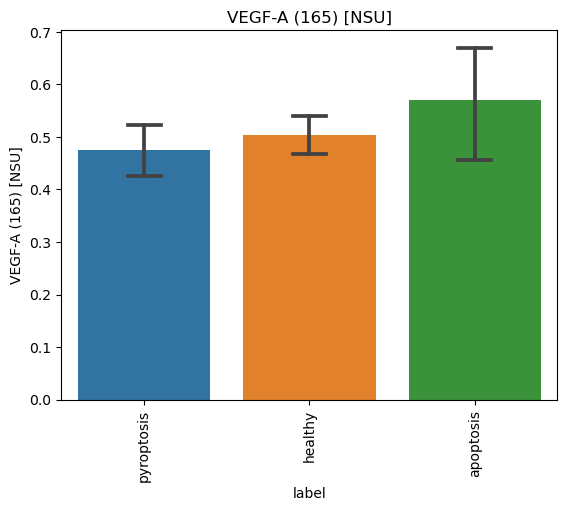

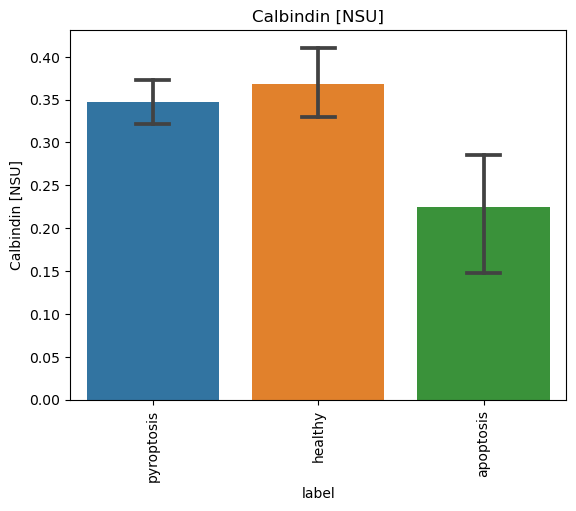

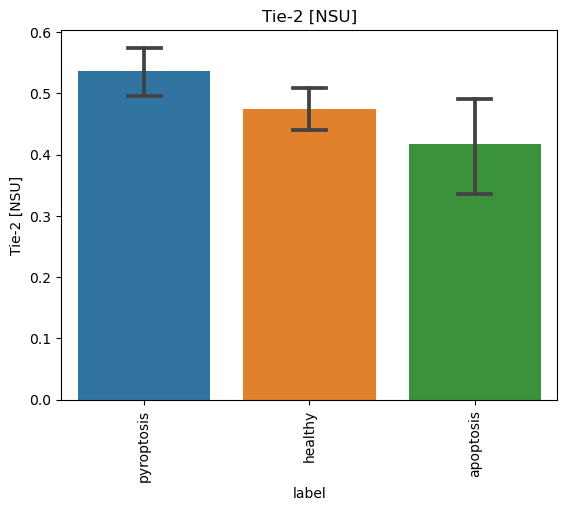

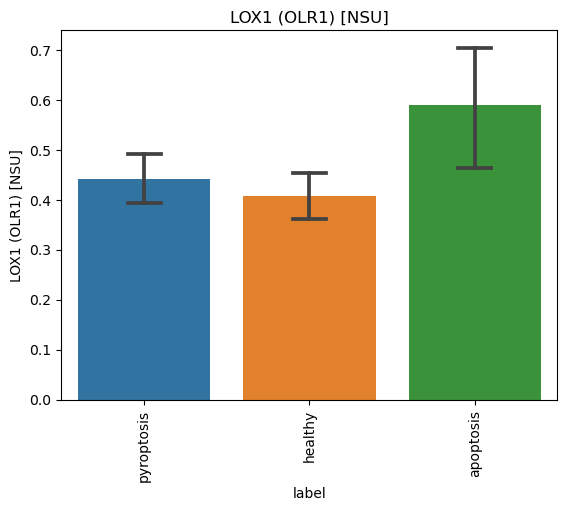

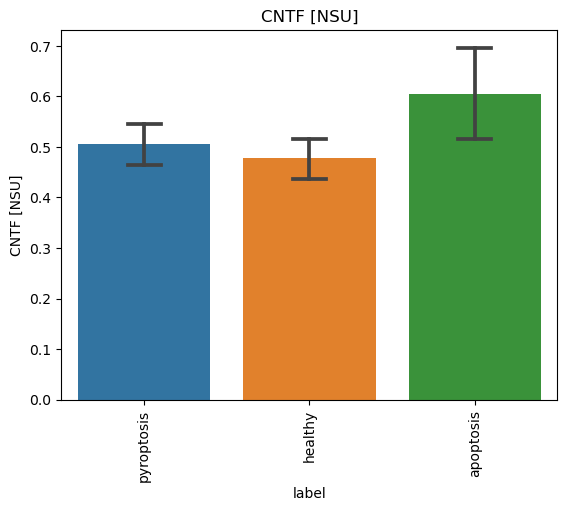

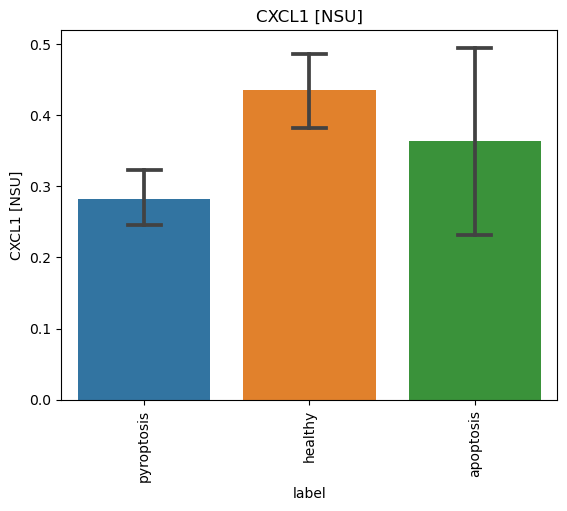

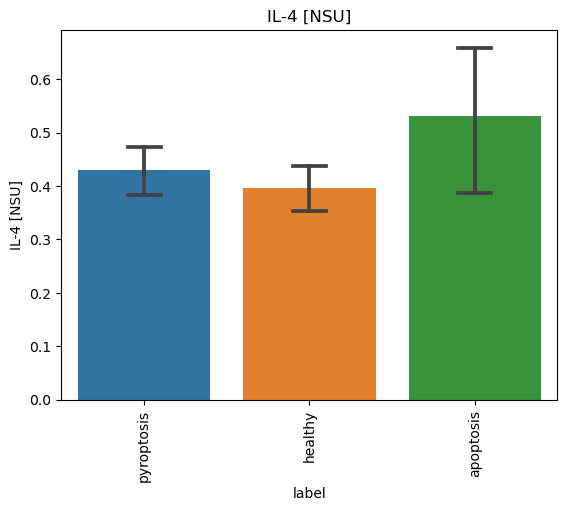

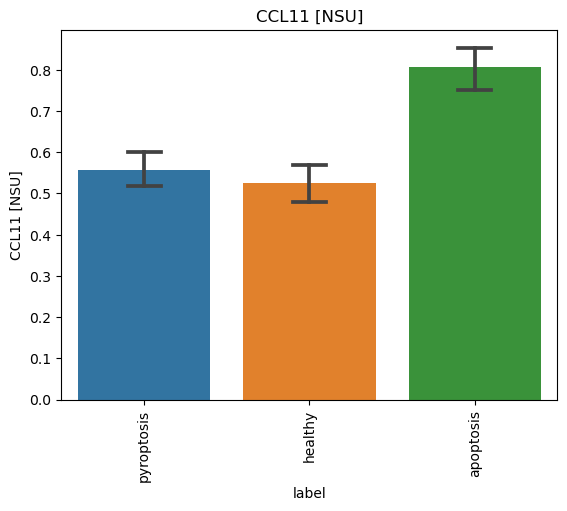

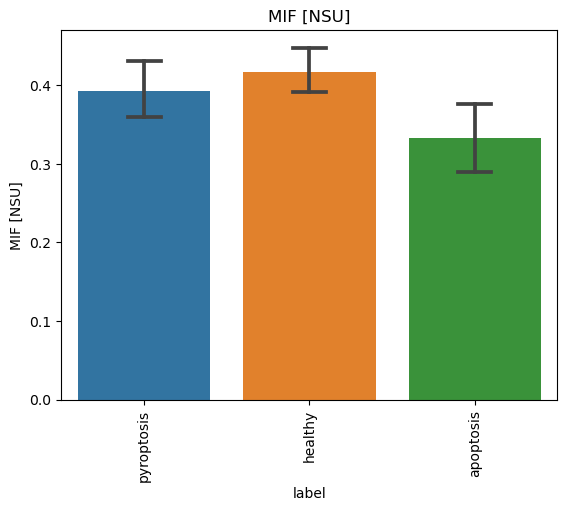

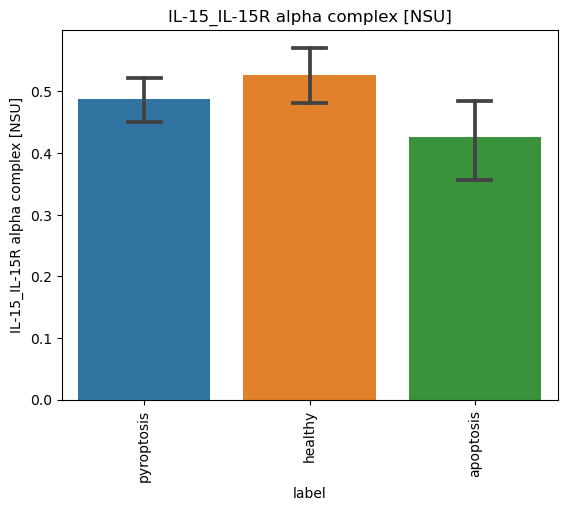

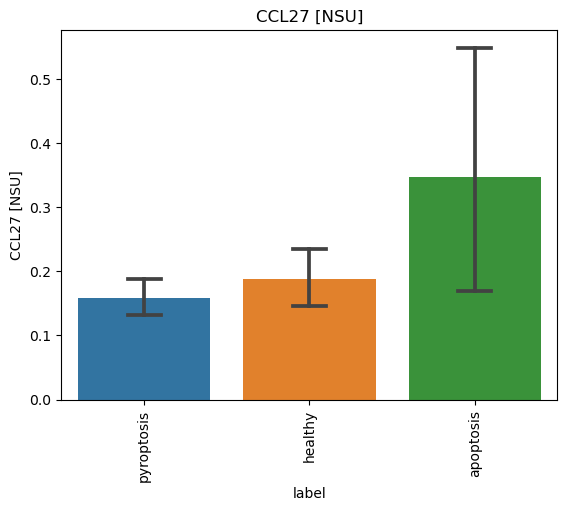

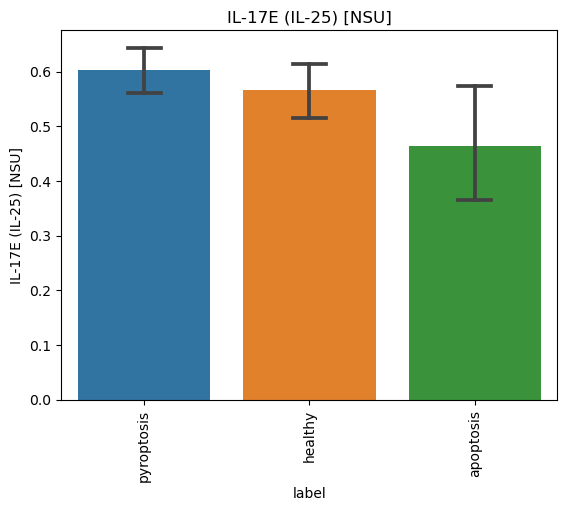

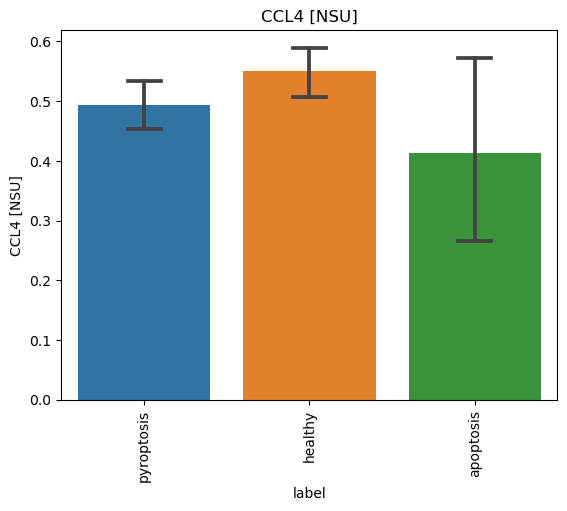

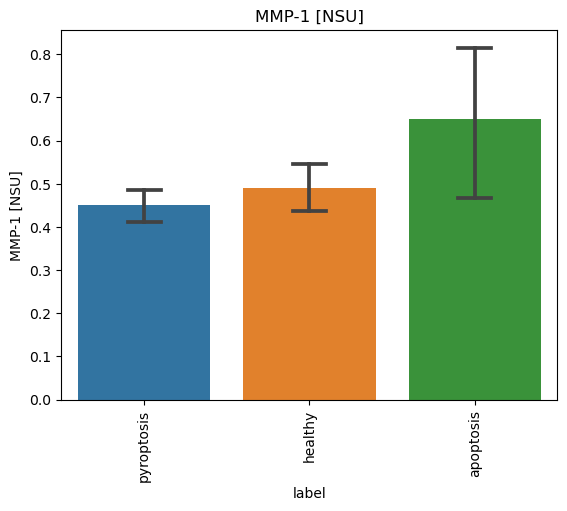

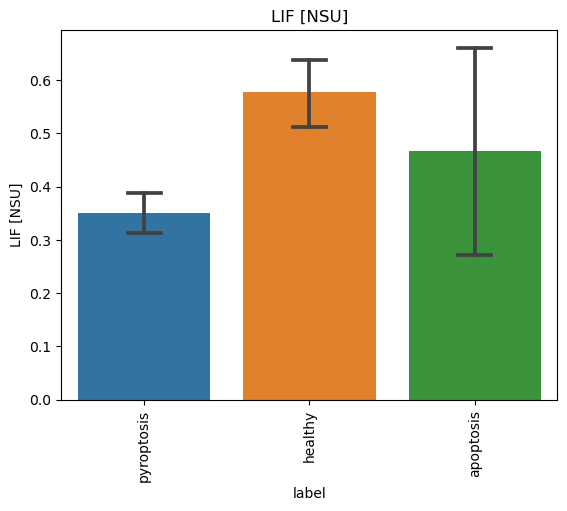

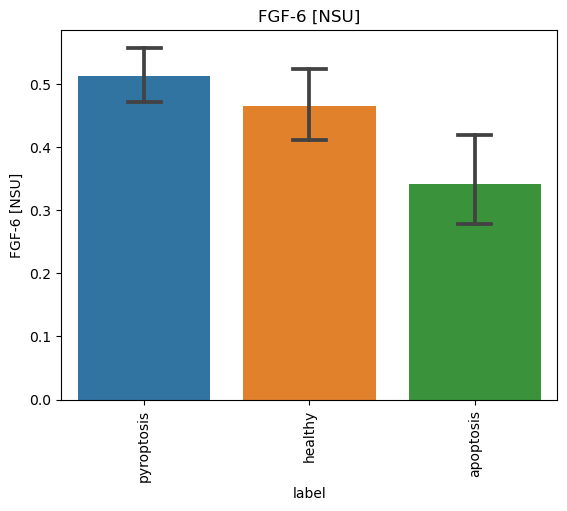

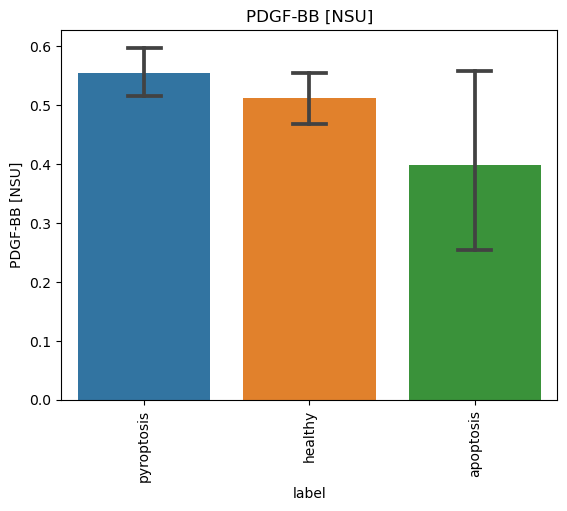

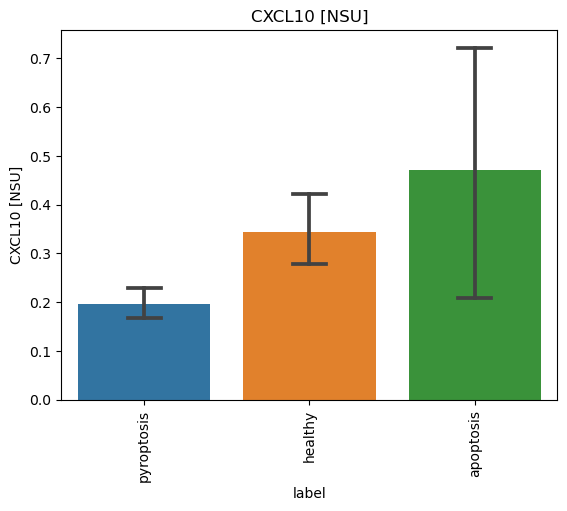

In [16]:
# graph each cytokine
for col in final_df_tukey["cytokine"].unique():
    sns.barplot(
        x="label",
        y=col,
        data=df,
        capsize=0.2,
    )
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show()
# feature pick
cytokines = [
    "Activin A [NSU]",
    "IL-1 alpha [NSU]",
    "IL-1 beta [NSU]",
    "Oncostatin M (OSM) [NSU]",
    "IFN gamma [NSU]",
    "Osteopontin (OPN) [NSU]",
    "TNF alpha [NSU]",
    "EMMPRIN [NSU]",
    "G-CSF [NSU]",
    "MMP-9 [NSU]",
    "IL-6 [NSU]",
    "MIF [NSU]",
    "IL-16 [NSU]",
    "IL-22 [NSU]",
    "IL-18 [NSU]",
    "CCL24 [NSU]",
    "CCL20 [NSU]",
    "CXCL11 [NSU]",
    "CXCL1 [NSU]",
]

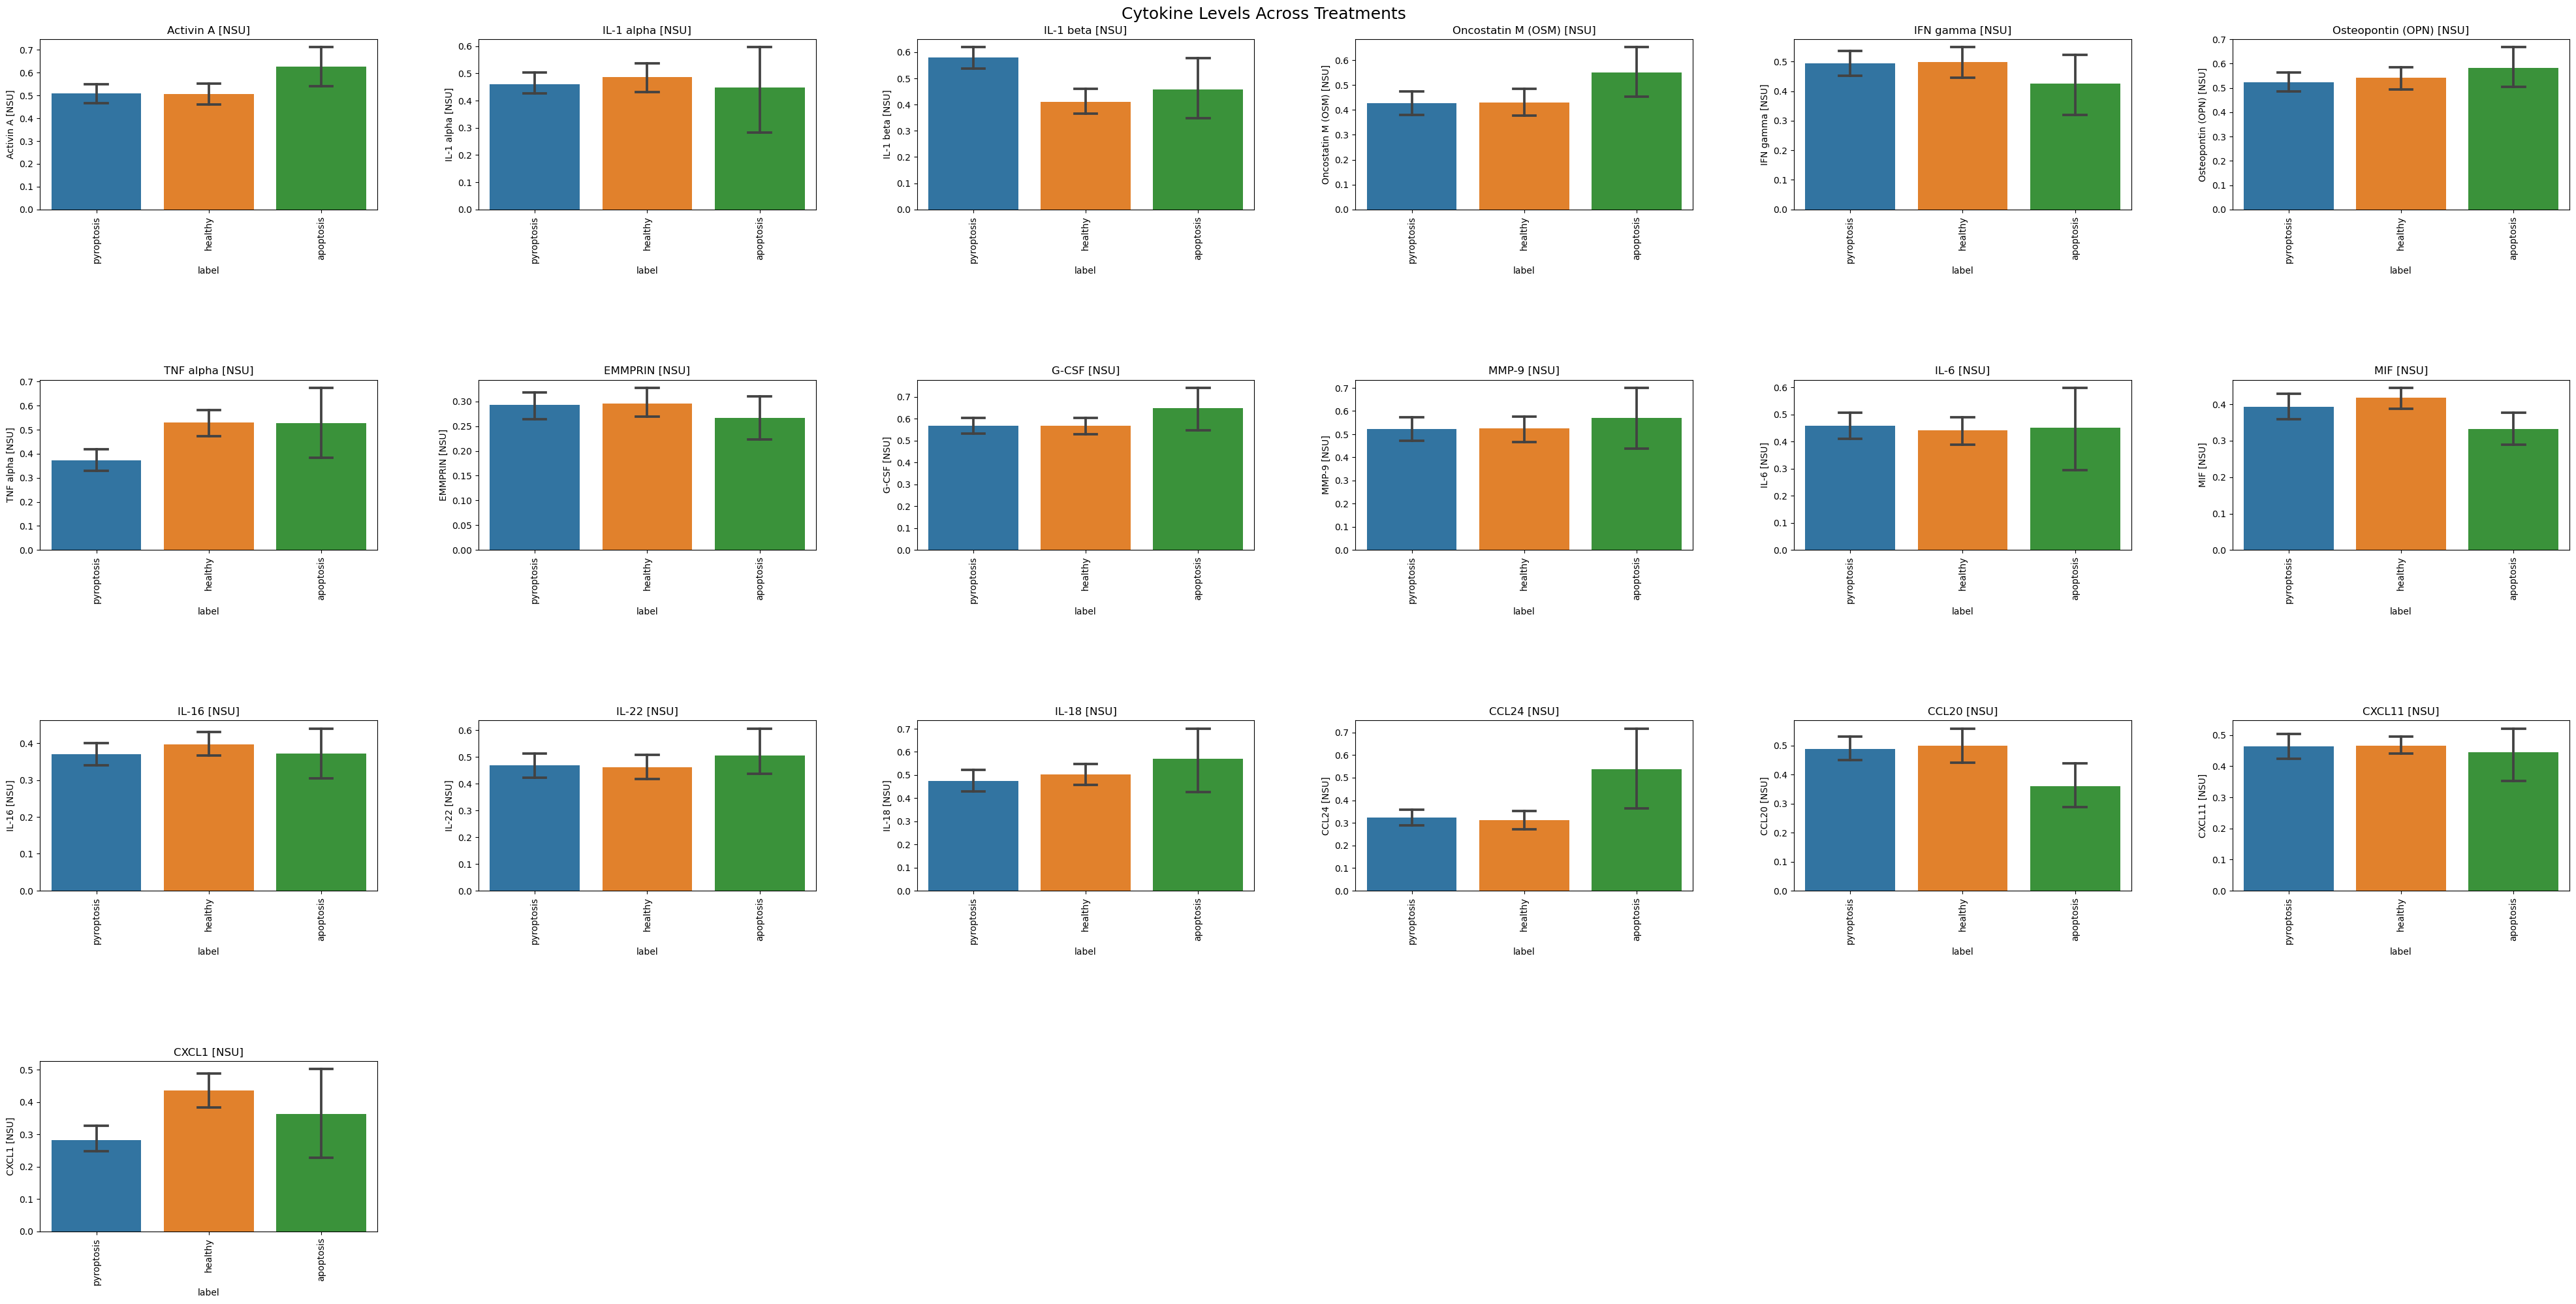

In [17]:
# drop all columns that are not in cytokines list
selected_cytokines = df[cytokines]

# plot the results of the tukey test for each cytokine
a = len(selected_cytokines.columns)
b = 6
plt.figure(figsize=(50, 100))
plt.suptitle("Cytokine Levels Across Treatments", fontsize=18)
plt.subplots_adjust(top=0.975, bottom=0.01, hspace=1, wspace=0.3)
for col in enumerate(selected_cytokines.columns):
    plt.subplot(a, b, col[0] + 1)
    sns.barplot(
        x="label",
        y=col[1],
        data=df,
        capsize=0.2,
    )
    # # title
    plt.title(col[1])
    # rotate xticks 90 degrees
    plt.xticks(rotation=90)
# set path for saving plot
pathlib.Path(f"./figures/").mkdir(parents=True, exist_ok=True)
# save plot
plt.savefig(f"./figures/selected_cytokines.png", bbox_inches="tight")
# # show plot
plt.show()

In [18]:
# save the final_df_tukey df to a csv file
final_df_tukey.to_csv("results/tukey_test_results.csv", index=False)

# write the cytokines column to a csv file
cytokines
with open("results/cytokines.csv", "w") as f:
    f.write("cytokine\n")
    for item in cytokines:
        f.write(f"{item}\n")
    f.close()